# Цель проекта: 
1. Изучить данный о коровах с экофермы и требования фермера.
2. Создать две модели, которые подскажут фермеру, какие коровы соответсвют его строгим критериям.
3. Доработать модели до качественного результата. 
## План проекта:
    1. Загрузить данные из трех датасетов\
        -Данные фермера\
        -Данные экофермы\
        -Данные с отцами коров.
    2. Изучить данные.
    3. Провести предобработку данных.
    4. Провести исследовательский анализ данных.
    5. Обучить 3 модели линейной регрессии. Выбрать лучшую из них.
    6. Предсказать целевой признак. Написать вывод.
    7. Обучить модель логистической регресии.
    8. Предсказать целевой признак.
    9. Написать вывод и дать рекомендации фермеру.

## Загрузка данных

###  Загрузим библиотеки и сохраним данные в датафреймы, изучим их.

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from phik import resources
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
df_farm = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';')
df_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';')
df_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')

In [4]:
print(df_farm.head(10),df_buy.head(10), df_dad.head(10))

   id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   
5   6      5254                                  12,7              1806   
6   7      5910                                  13,2              1792   
7   8      6179                                  14,7              1806   
8   9      6783                                  14,2              1918   
9  10      5339                                  13,4              1791   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                             

In [5]:
print(df_farm.info(),df_buy.info(),df_dad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

По первой оценки видны не коректные значения столбцов, далее поменяем.

##  Предобработка данных

### Приведем названия колонок.

In [6]:
dt = [df_farm,df_dad,df_buy]

def rname(df):
    df.columns = df.columns.str.lower()
for i in dt:
    rname(i)

### Проверим на пропуски данные:

In [7]:
def miss(data):
    return pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

In [8]:
miss(df_buy)

,0
порода,0.000000
тип пастбища,0.000000
порода папы_быка,0.000000
имя_папы,0.000000
"текущая_жирность,%",0.000000
"текущий_уровень_белок,%",0.000000
возраст,0.000000


In [9]:
miss(df_farm)

,0
id,0.000000
"удой, кг",0.000000
эке (энергетическая кормовая единица),0.000000
"сырой протеин, г",0.000000
спо (сахаро-протеиновое соотношение),0.000000
порода,0.000000
тип пастбища,0.000000
порода папы_быка,0.000000
"жирность,%",0.000000
"белок,%",0.000000


In [10]:
miss(df_dad)

,0
id,0.000000
имя папы,0.000000


Пропусков в данных нет.

### Проверим на очевидные дупликаты.

In [11]:
dt = [df_farm, df_dad, df_buy]

for indx,i in enumerate(dt):
    print('В датафрейме', indx+1, 'обнаруженно', i.duplicated().sum(),'повторов')

В датафрейме 1 обнаруженно 5 повторов
В датафрейме 2 обнаруженно 0 повторов
В датафрейме 3 обнаруженно 4 повторов


#### В двух датафреймах найдены дупликаты, удалим их.

In [12]:
df_farm = df_farm.drop_duplicates(keep='first').reset_index(drop=True)
df_buy = df_buy.drop_duplicates(keep='first').reset_index(drop=True)

In [13]:
dt = [df_farm,df_dad,df_buy]

for indx,i in enumerate(dt):
    print('В датафрейме', indx+1, 'обнаруженно', i.duplicated().sum(),'повторов')

В датафрейме 1 обнаруженно 0 повторов
В датафрейме 2 обнаруженно 0 повторов
В датафрейме 3 обнаруженно 0 повторов


### Переименуем столбцы в датафрейме с информацией от фермера.

In [14]:
df_farm.head(10)

,id,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
5,6,5254,"12,7",1806,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,13","3,078",вкусно,менее_2_лет
6,7,5910,"13,2",1792,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,48","3,077",вкусно,более_2_лет
7,8,6179,"14,7",1806,"0,93",Вис Бик Айдиал,Равнинные,Айдиал,"3,55","3,076",вкусно,более_2_лет
8,9,6783,"14,2",1918,"0,94",РефлешнСоверинг,Холмистое,Айдиал,"3,71","3,077",вкусно,более_2_лет
9,10,5339,"13,4",1791,"0,895",Вис Бик Айдиал,Холмистое,Соверин,"3,13","3,075",вкусно,менее_2_лет


In [15]:
df_farm = df_farm.rename(columns={'удой, кг': 'удой', 'эке (энергетическая кормовая единица)': 'эке',
                                  'спо (сахаро-протеиновое соотношение)':'спо', 'порода папы_быка':'порода_папы',
                                  'сырой протеин, г':'протеин', 'тип пастбища':'пастбище', 'жирность,%':'жирность',
                                  'белок,%':'белок','вкус молока':'вкус'})

Поменяем формат некоторых колонок.

In [16]:
df_farm = df_farm.replace(',', '.', regex=True)
df_farm['спо'] = df_farm['спо'].astype('float64')
df_farm['эке'] = df_farm['эке'].astype('float64')
df_farm['жирность'] = df_farm['жирность'].astype('float64')
df_farm['белок'] = df_farm['белок'].astype('float64')

### Проверим на неочевидные дупликаты.

In [17]:
d = [df_farm['порода'], df_farm['пастбище'], df_farm['порода_папы']]
for i in d:
    print(i.unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']


Видим повторяющиеся значения. Заменим их.

In [18]:
df_farm['пастбище'] = df_farm['пастбище'].replace('Равнинные', 'равнинное', regex=True).str.lower()
df_farm['порода_папы'] = df_farm['порода_папы'].replace('Айдиалл','Айдиал', regex=True)

In [19]:
for i in d:
    print(i.unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['равнинное' 'холмистое']
['Айдиал' 'Соверин']


### Переименуем столбцы в датафрейме с информацией от экофермы.   
    

In [20]:
df_buy.head(10)

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,"3,73","3,055",более_2_лет
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,73","3,073",более_2_лет


In [21]:
df_buy = df_buy.rename(columns={'тип пастбища':'пастбище','порода папы_быка':'порода_папы','текущая_жирность,%':'жирность',
                               'текущий_уровень_белок,%':'белок'})

In [22]:
df_buy

,порода,пастбище,порода_папы,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,"3,73","3,055",более_2_лет
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,73","3,073",более_2_лет


In [23]:
df_buy= df_buy.replace(',', '.', regex=True)
df_buy['жирность'] = df_farm['жирность'].astype('float64')
df_buy['белок'] = df_buy['белок'].astype('float64')

### Проверим данные, в дата фрейме с отцами коров.

In [24]:
df_dad.head(10)

,id,имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [25]:
df_dad = df_dad.rename(columns={'имя папы':'имя_папы'})

## Вывод по разделу:
1. Исправили названия колонок и привели их к нижнему регистру.
2. Удалили строки дупликаты из дата фрейма.
3. Нашел не очевидные дупликаты, видимо были допущены ошибки в заполнении данных, заменил их на правильные.
4. Изменил формат колонок с числовыми показателями на float64

## Исследовательский анализ данных

### Проведем исследование по данным фермера

In [26]:
df_farm.head()

,id,удой,эке,протеин,спо,порода,пастбище,порода_папы,жирность,белок,вкус,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [27]:
df_farm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           629 non-null    int64  
 1   удой         629 non-null    int64  
 2   эке          629 non-null    float64
 3   протеин      629 non-null    int64  
 4   спо          629 non-null    float64
 5   порода       629 non-null    object 
 6   пастбище     629 non-null    object 
 7   порода_папы  629 non-null    object 
 8   жирность     629 non-null    float64
 9   белок        629 non-null    float64
 10  вкус         629 non-null    object 
 11  возраст      629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


Сделаем функцию для построения графиков.

In [28]:
def inf(data):
    for i in data:
        plt.figure(figsize=(10, 6))
        try:
            data[i].plot(kind='hist', title=i, bins=18)
            print(i)
            print(data[i].describe())
            plt.ylabel('Кол-во наблюдений')
            plt.grid(axis='y')
            plt.show()
        except:
            df1 = data.groupby(i).size()
            df1.plot(kind='bar', title=i)
            plt.ylabel('Кол-во наблюдений')
            plt.grid(axis='y')
            plt.show() 

id
count    629.00000
mean     315.00000
std      181.72094
min        1.00000
25%      158.00000
50%      315.00000
75%      472.00000
max      629.00000
Name: id, dtype: float64


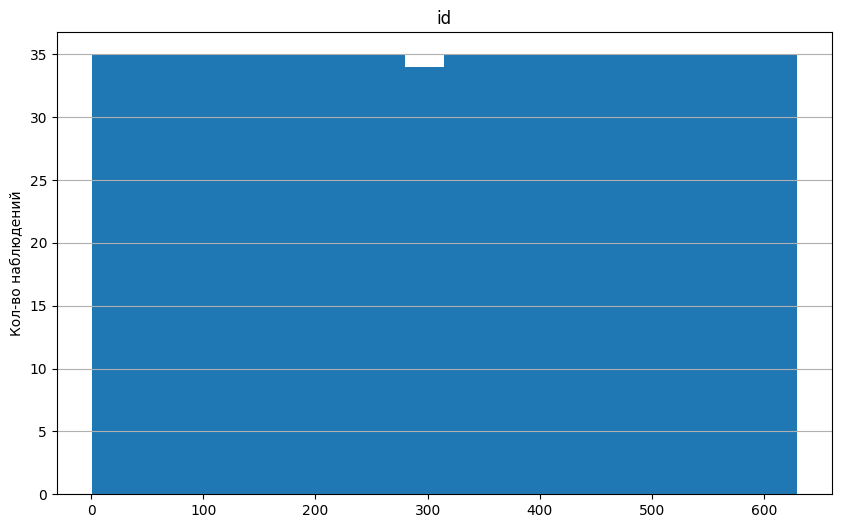

удой
count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой, dtype: float64


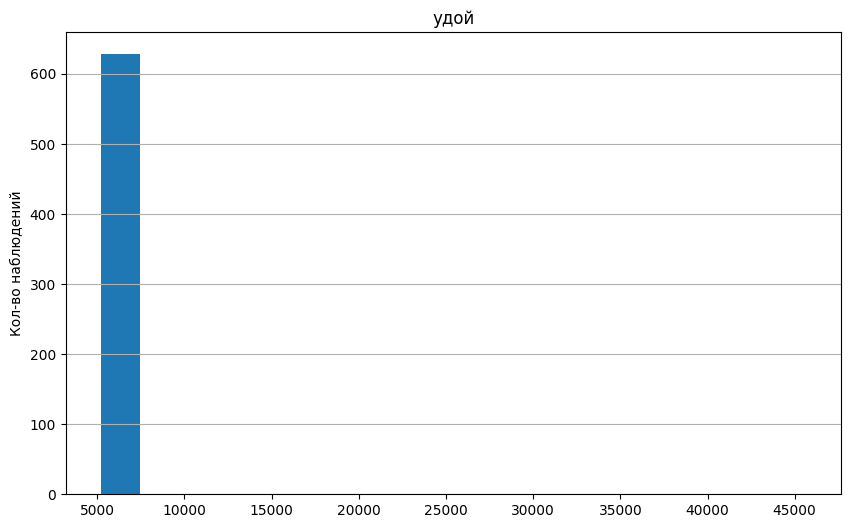

эке
count    629.000000
mean      14.543879
std        1.306408
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64


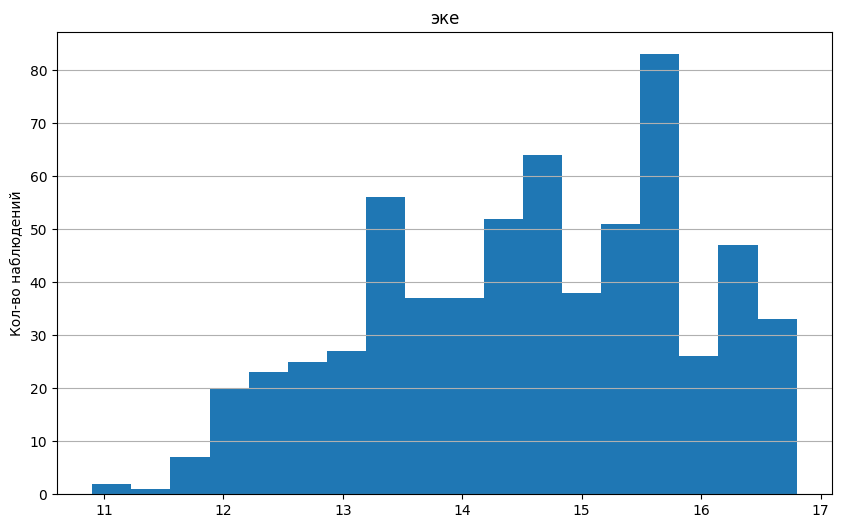

протеин
count     629.000000
mean     1923.364070
std       182.956251
min      1660.000000
25%      1771.000000
50%      1888.000000
75%      2062.000000
max      2349.000000
Name: протеин, dtype: float64


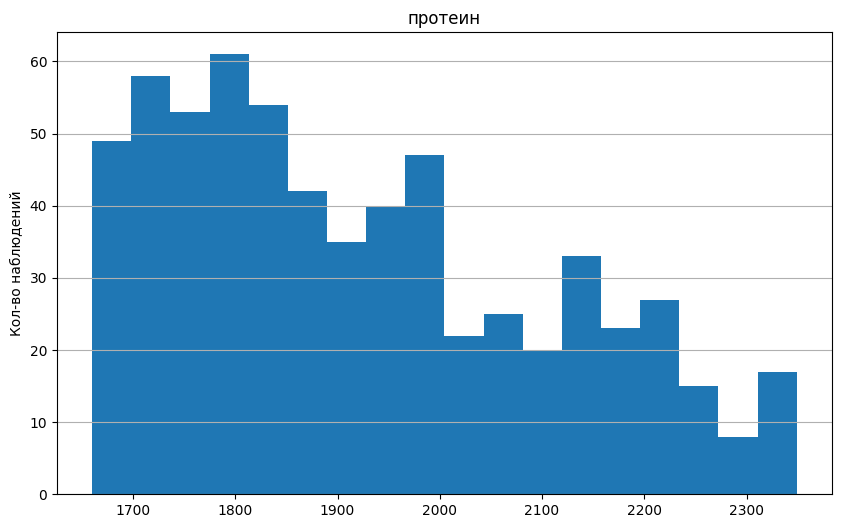

спо
count    629.000000
mean       0.913116
std        0.032203
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64


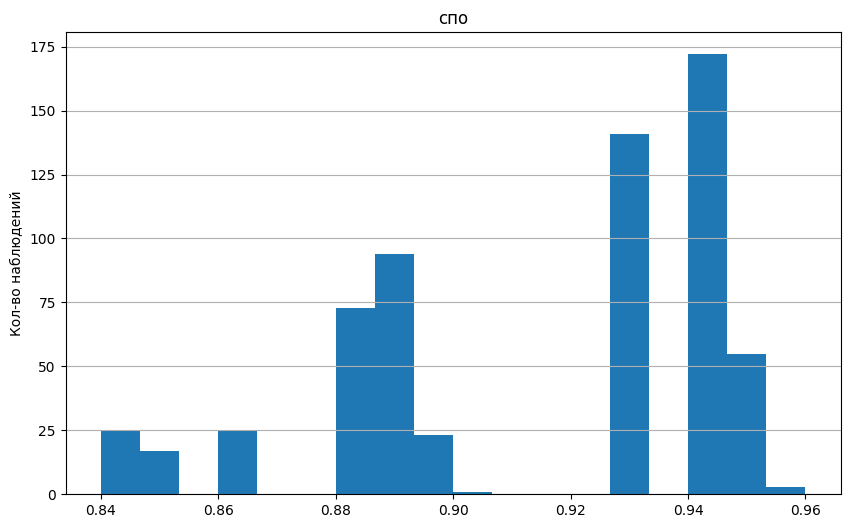

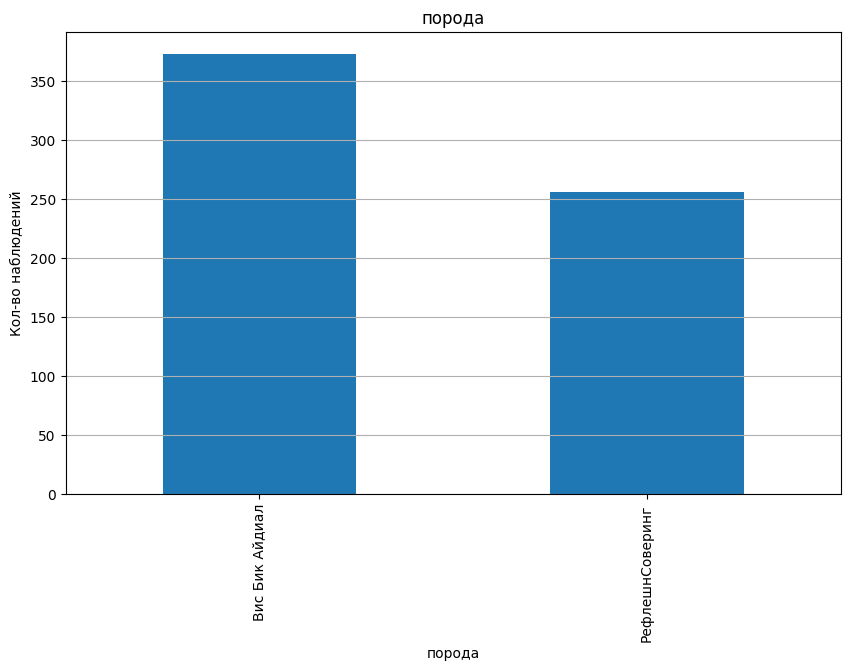

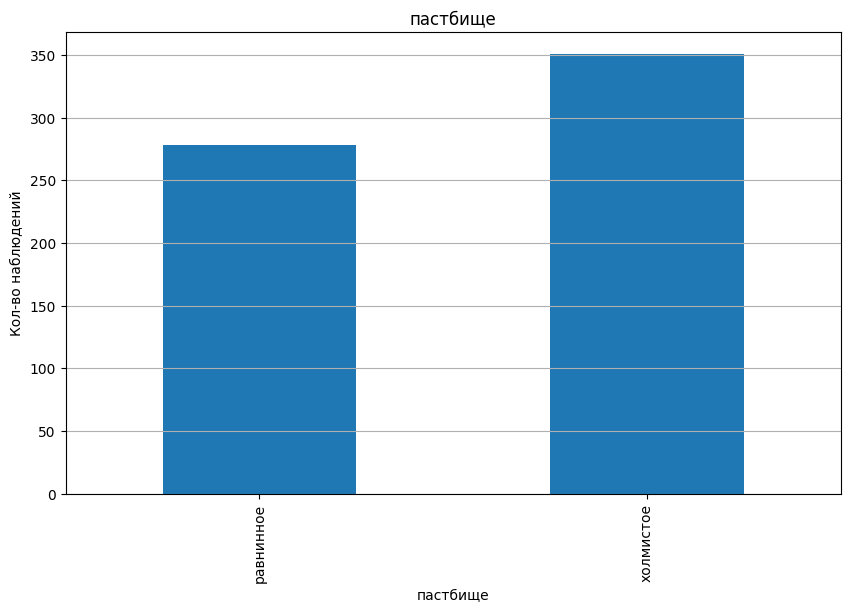

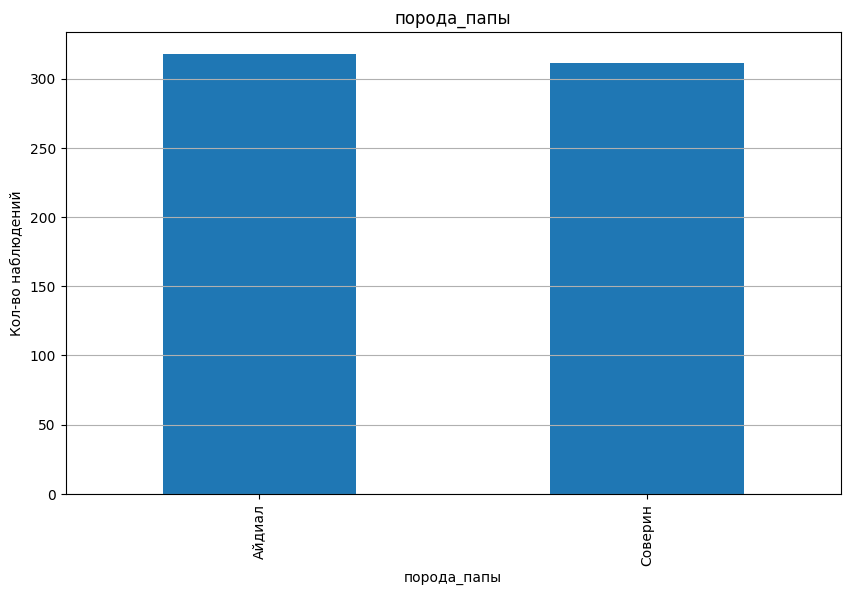

жирность
count    629.000000
mean       3.603657
std        0.168656
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64


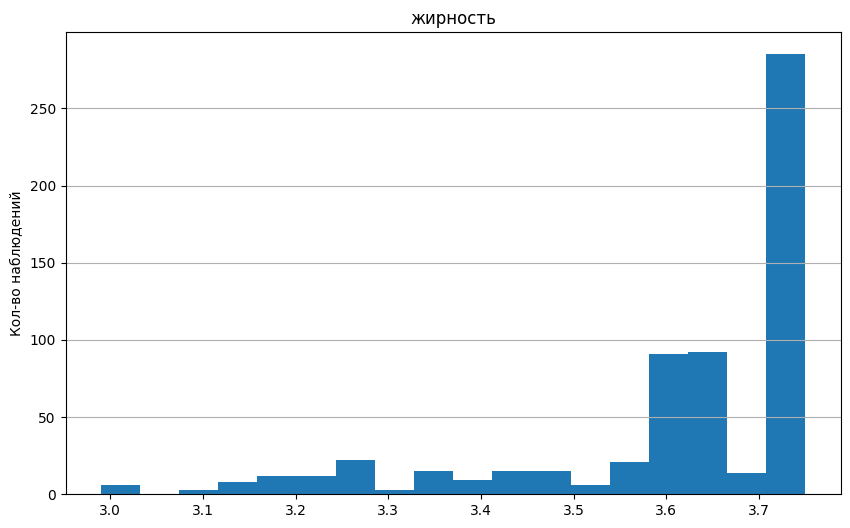

белок
count    629.000000
mean       3.075671
std        0.002549
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64


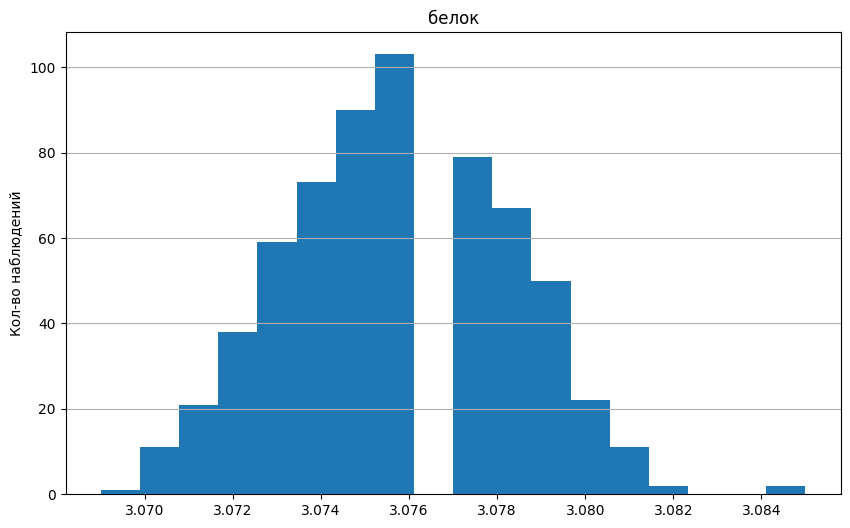

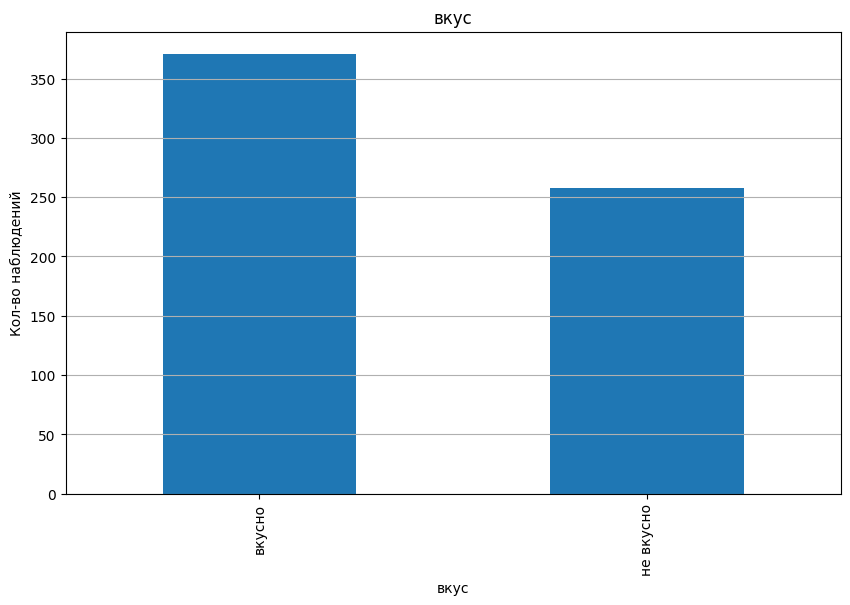

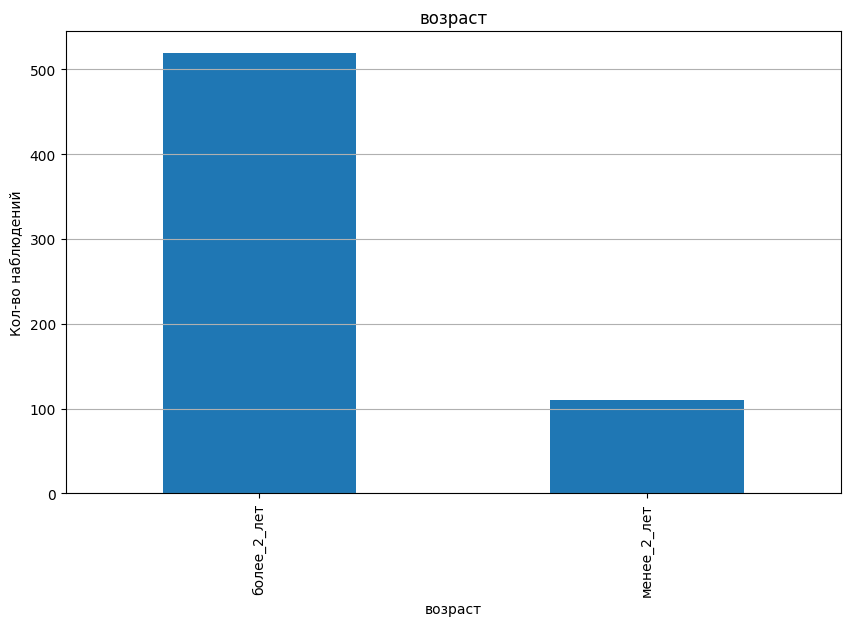

In [29]:
inf(df_farm)

Как видим есть лишняя информация в виде графика по колонке id.\
А так же большой выброс в графике удоя скота. Исправим это.

In [30]:
df = df_farm[df_farm['удой'] <= 10000]
df = df.drop('id', axis=1)

удой
count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой, dtype: float64


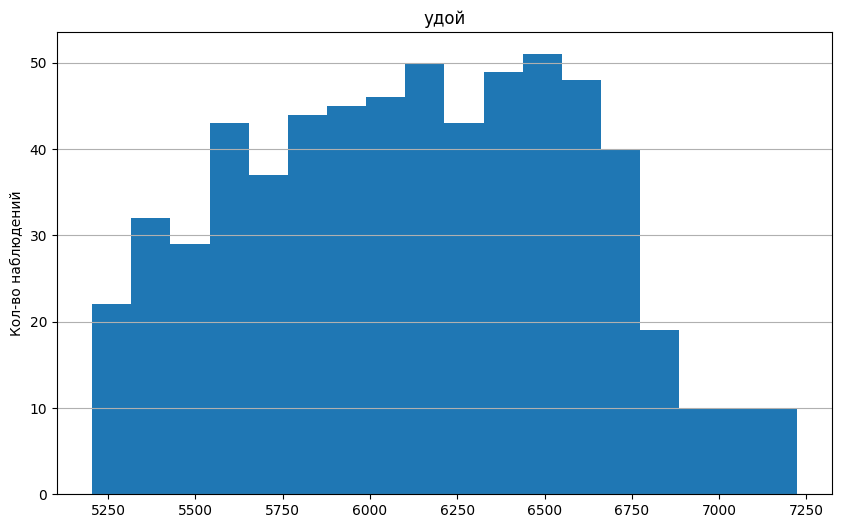

эке
count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64


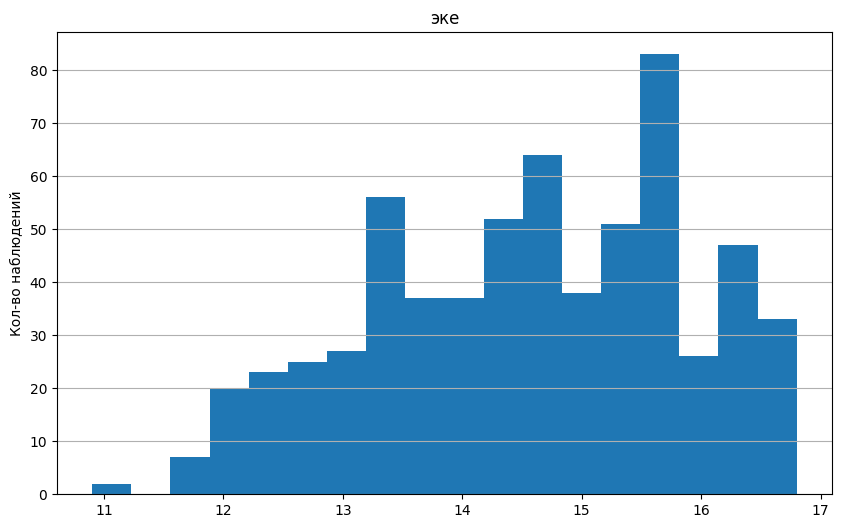

протеин
count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: протеин, dtype: float64


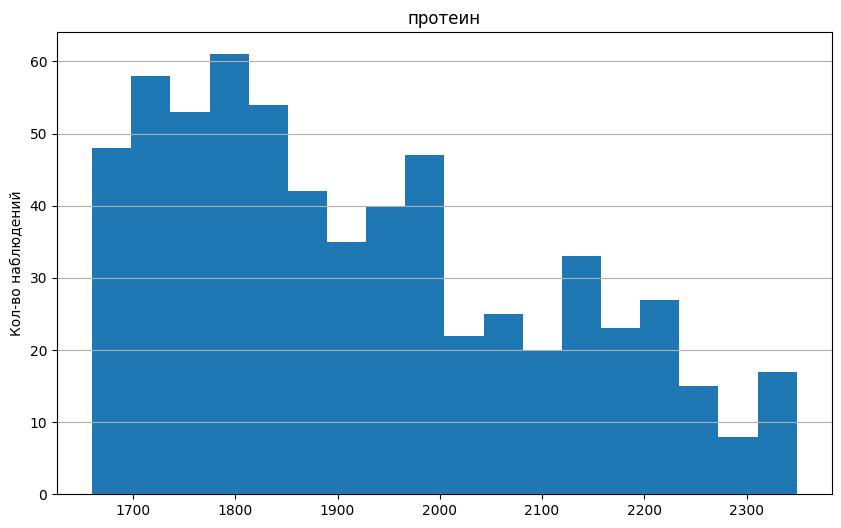

спо
count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64


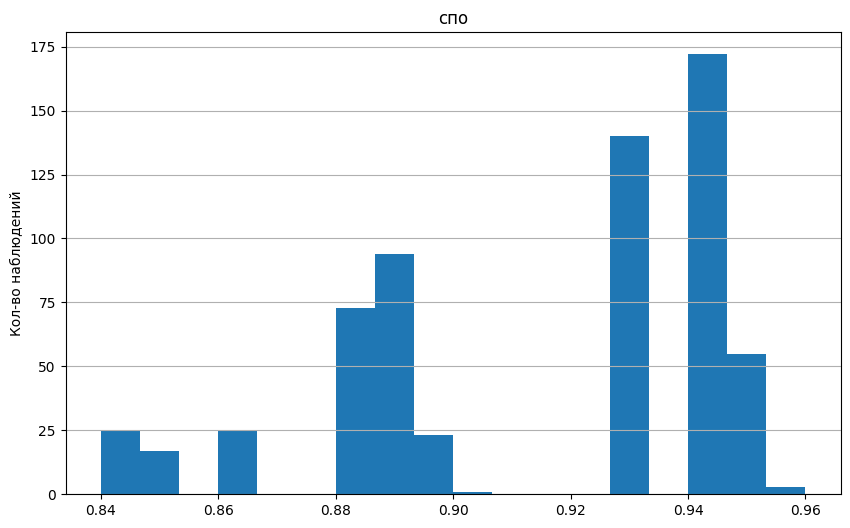

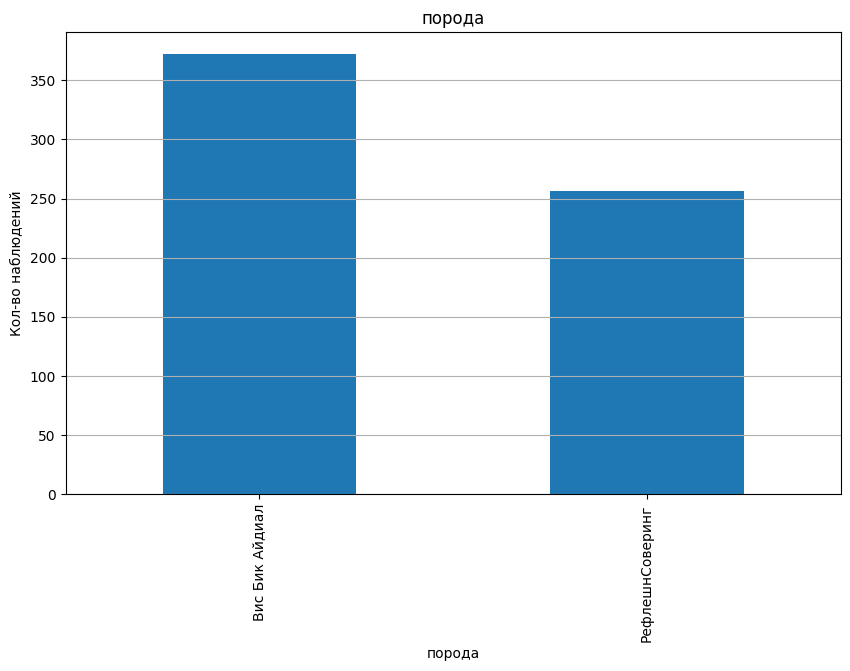

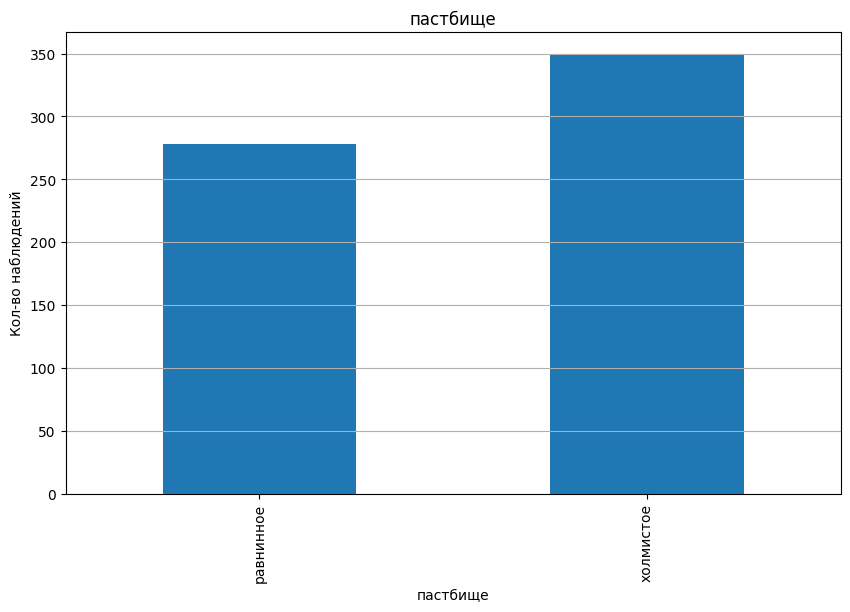

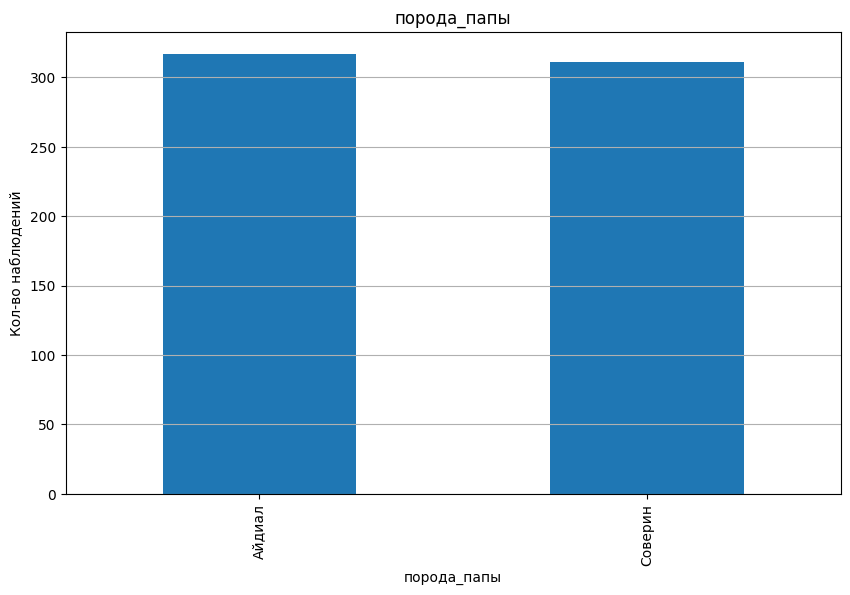

жирность
count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64


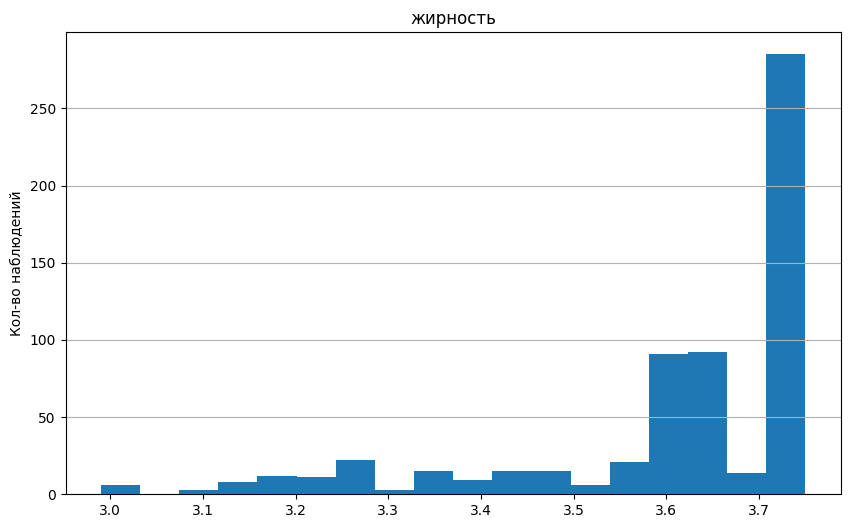

белок
count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64


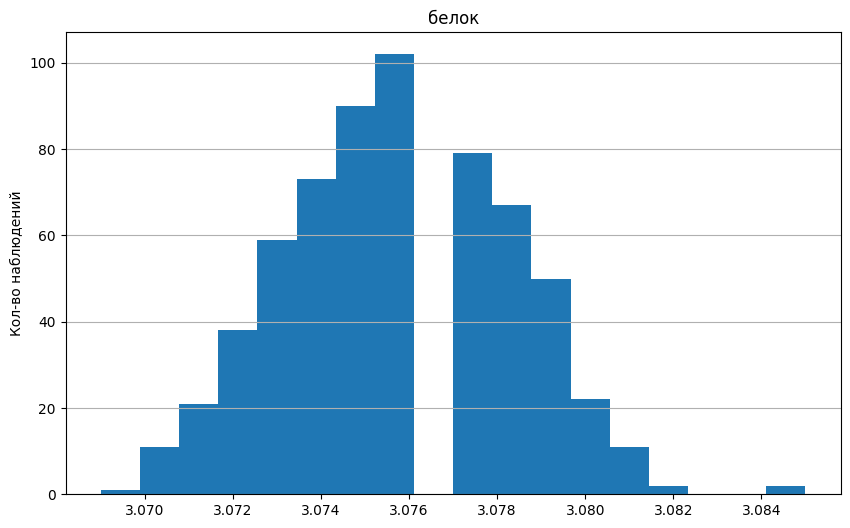

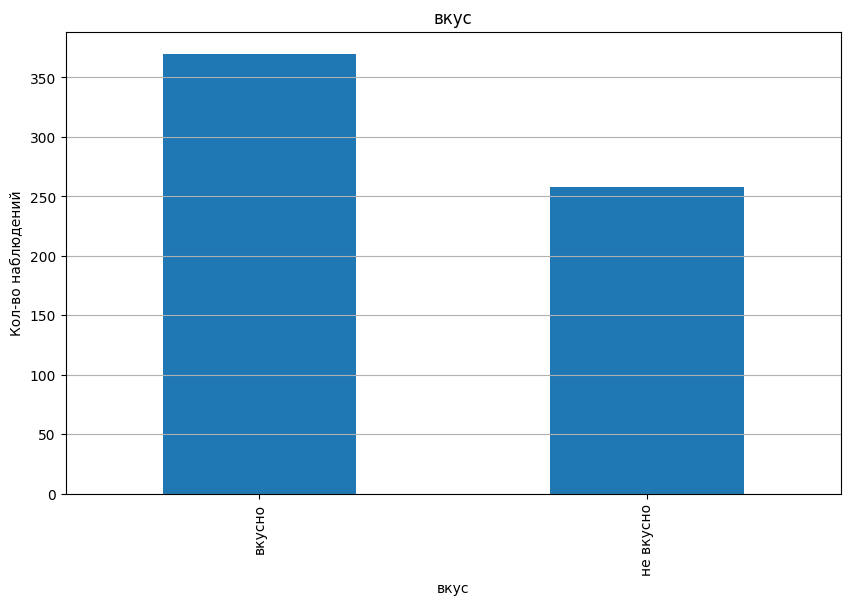

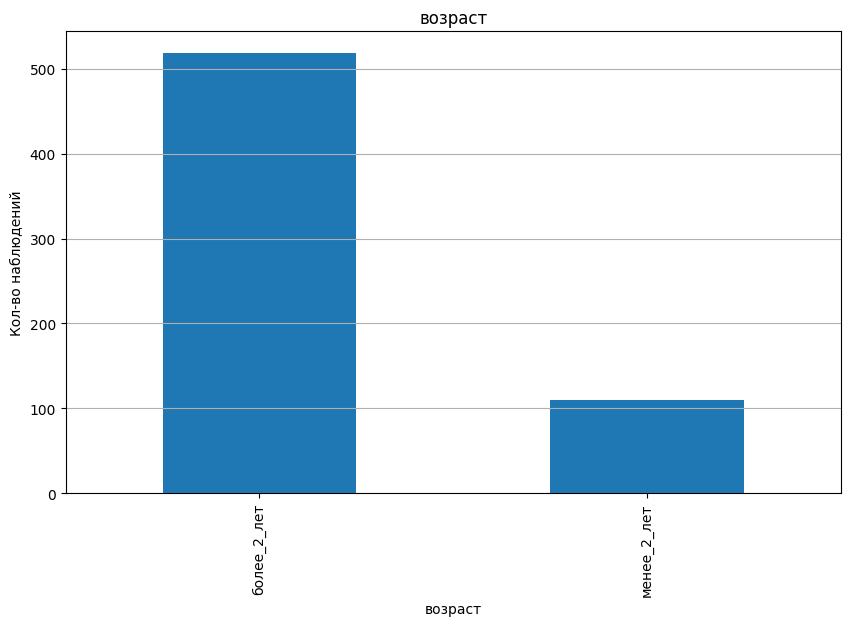

In [31]:
inf(df)

По графикам видим что среднее значение удоя 6125 кг молока в год.\
Эке(Энергетическая кормовая единица) среднее значение 14.5, однако видим 3 пика около 13,5, 14,5 и 15,5.\
Пик кол-ва протеина в молоке присходит на 1800 и далее снижается.\
Спо(Сахаро-протеиновое соотношение) так же имеет 3 пика.\
Больше всего в стаде фермера коров породы Вис Бик Айдиал.\
Больше всего коров пасутся на холмистом пастбище.\
Порода отца в среднем одинаковая для всего стада\
Жирность большего кол-ва молока составляет от 3.7 и выше.\
Кол-во белка в молоке приходится на пик 3.076 г. а так же имеет нормально распределние.
Более 350 коров дают вкусное молоко по оценкам фермера, и не вкусное молоко дают чуть более 250 коров
Большинству коров более 2 лет.

### Проведем исследование по данным c экофермы.

In [32]:
df_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   порода       16 non-null     object 
 1   пастбище     16 non-null     object 
 2   порода_папы  16 non-null     object 
 3   имя_папы     16 non-null     object 
 4   жирность     16 non-null     float64
 5   белок        16 non-null     float64
 6   возраст      16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


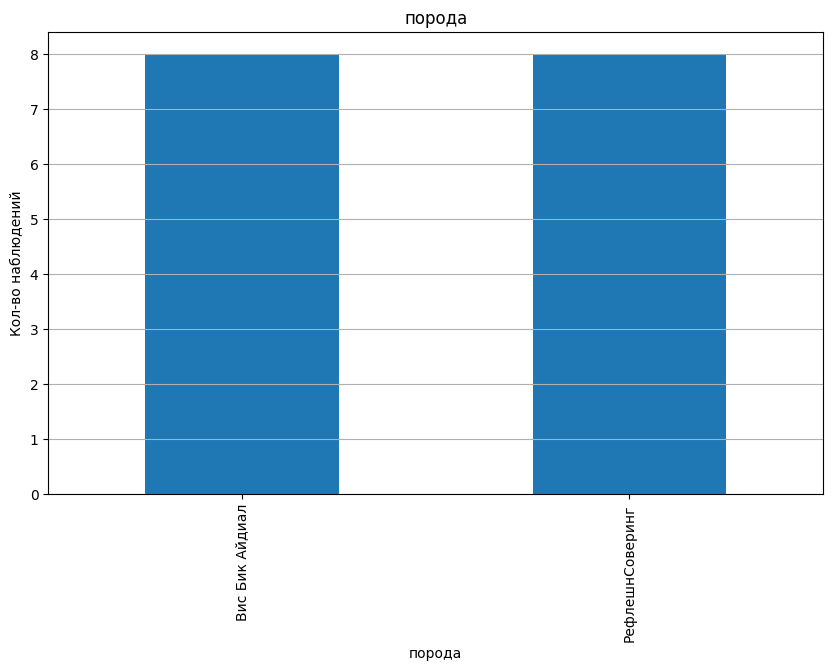

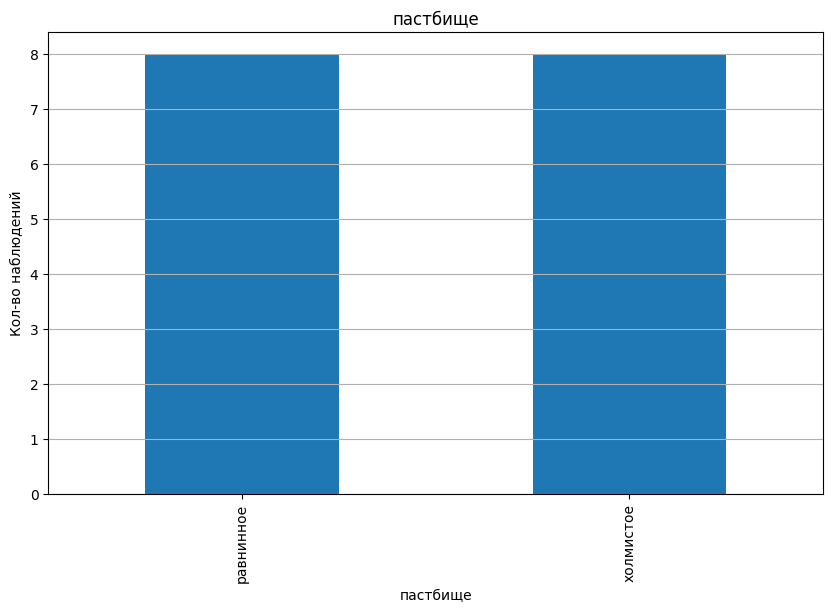

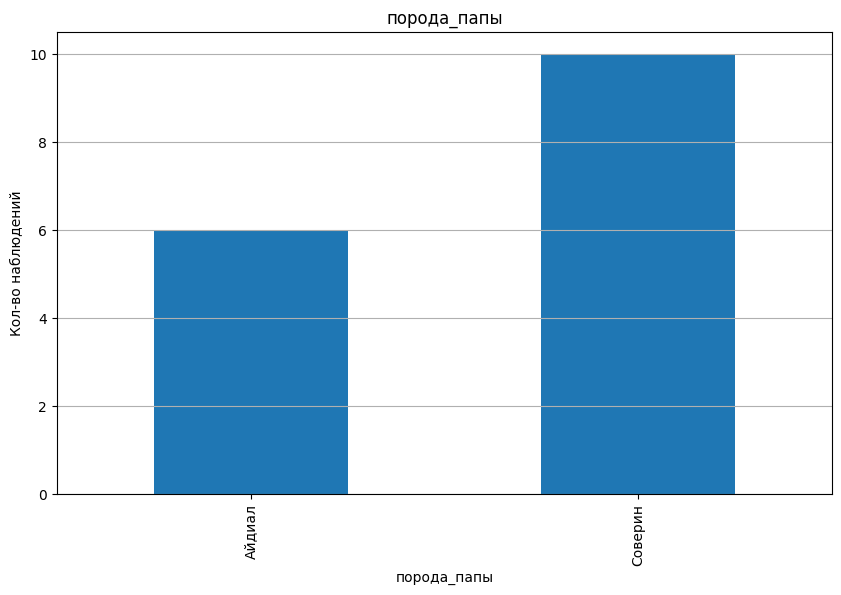

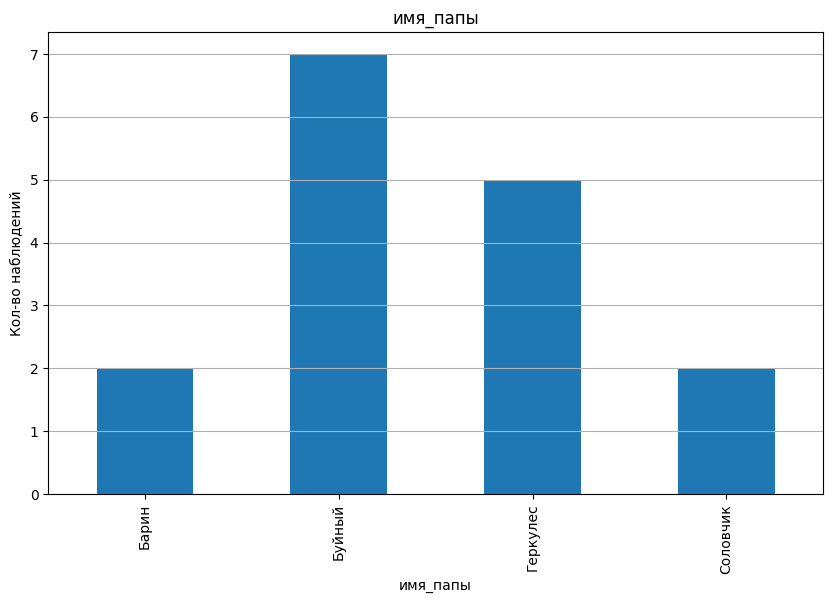

жирность
count    16.000000
mean      3.528125
std       0.219946
min       3.130000
25%       3.460000
50%       3.585000
75%       3.710000
max       3.730000
Name: жирность, dtype: float64


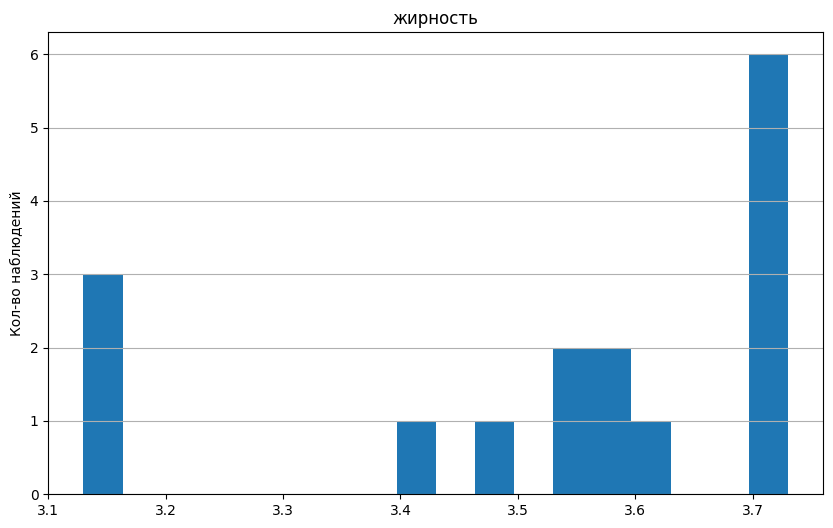

белок
count    16.000000
mean      3.068250
std       0.011264
min       3.046000
25%       3.059500
50%       3.073500
75%       3.076750
max       3.081000
Name: белок, dtype: float64


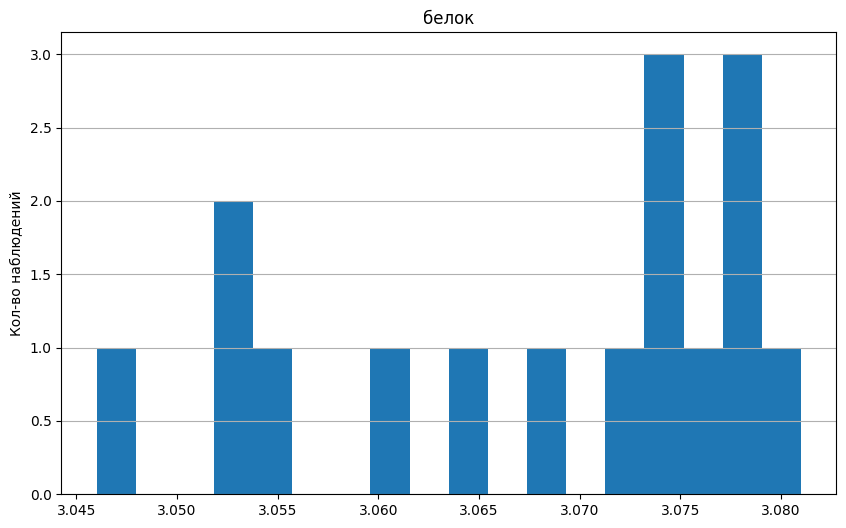

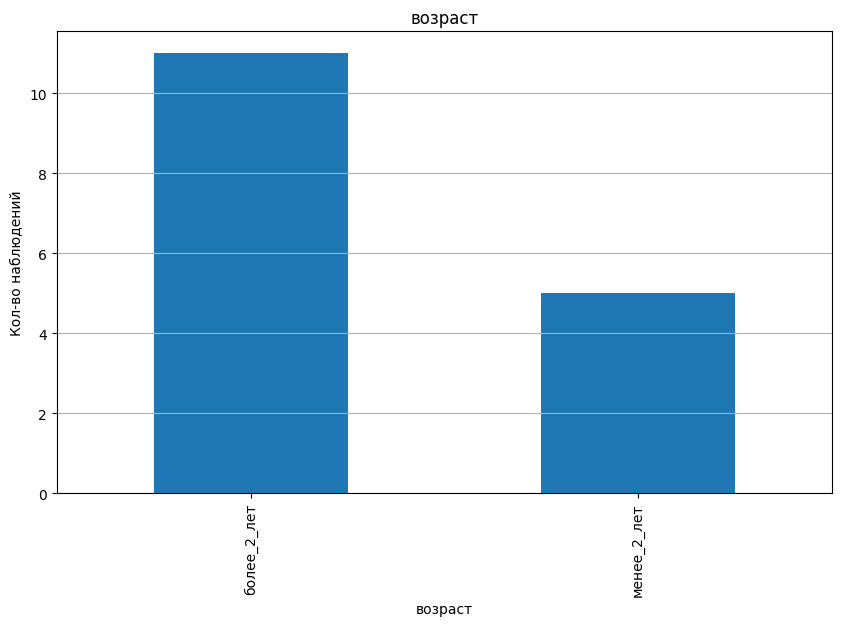

In [33]:
inf(df_buy)

Выбор у фермера представле 16 коровами.\
Более 11 коров старше двух лет.\
Средний процент протеина с которой коровы дают молоко 3.06, однако 3 коровы дают в диапазоне 3.070-3.075, а 3 коровы 3.075-3.080.\
Процент жирности у всех предлагаемых коров 3.47, но у 5 коров он составляет 3.7

## Вывод по исследовательскому анализу:
1. У фермера достаточно большое поголовье скота, которое дает разное по жирности и протеину молоко.\
2. Большинству коров более 2 лет.
3. Фермер удовлетворен вкусом молока у более чем 350 коров.
4. Средний удой молока 6125 кг в год.

## Корреляционный анализ

Построим хитмап и датаматрикс зависимостей показателей поголовья скота фермера.

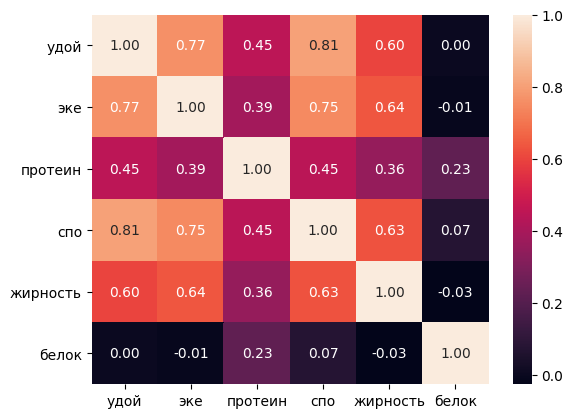

In [34]:
df = df_farm[df_farm['удой'] <= 10000] # Как мы помним у нас есть аномальное значение в удое, а так же не показательная информация id.
df = df.drop('id', axis=1)
sns.heatmap(df.corr(), annot=True, fmt='.2f');

#### По хитмапу видно:
    1.Удой сильно зависит от Эке(энергетической кормовой единицы)(0.77) а так же, что удой сильно влияет на  Спо(сахаро-протеиновое соотношение)(0.81), и в меньшей степени на жирность(0.6) и протеин(0.45) в молоке.\
    2. Эке(энергетической кормовой единицы) имеет выраденную вильную кореляцию с Спо(сахаро-протеиновое соотношение)(0.75) и жирностью(0.64) в молоке, а так среднюю кореляцию с кол-вом протеина(0.39)

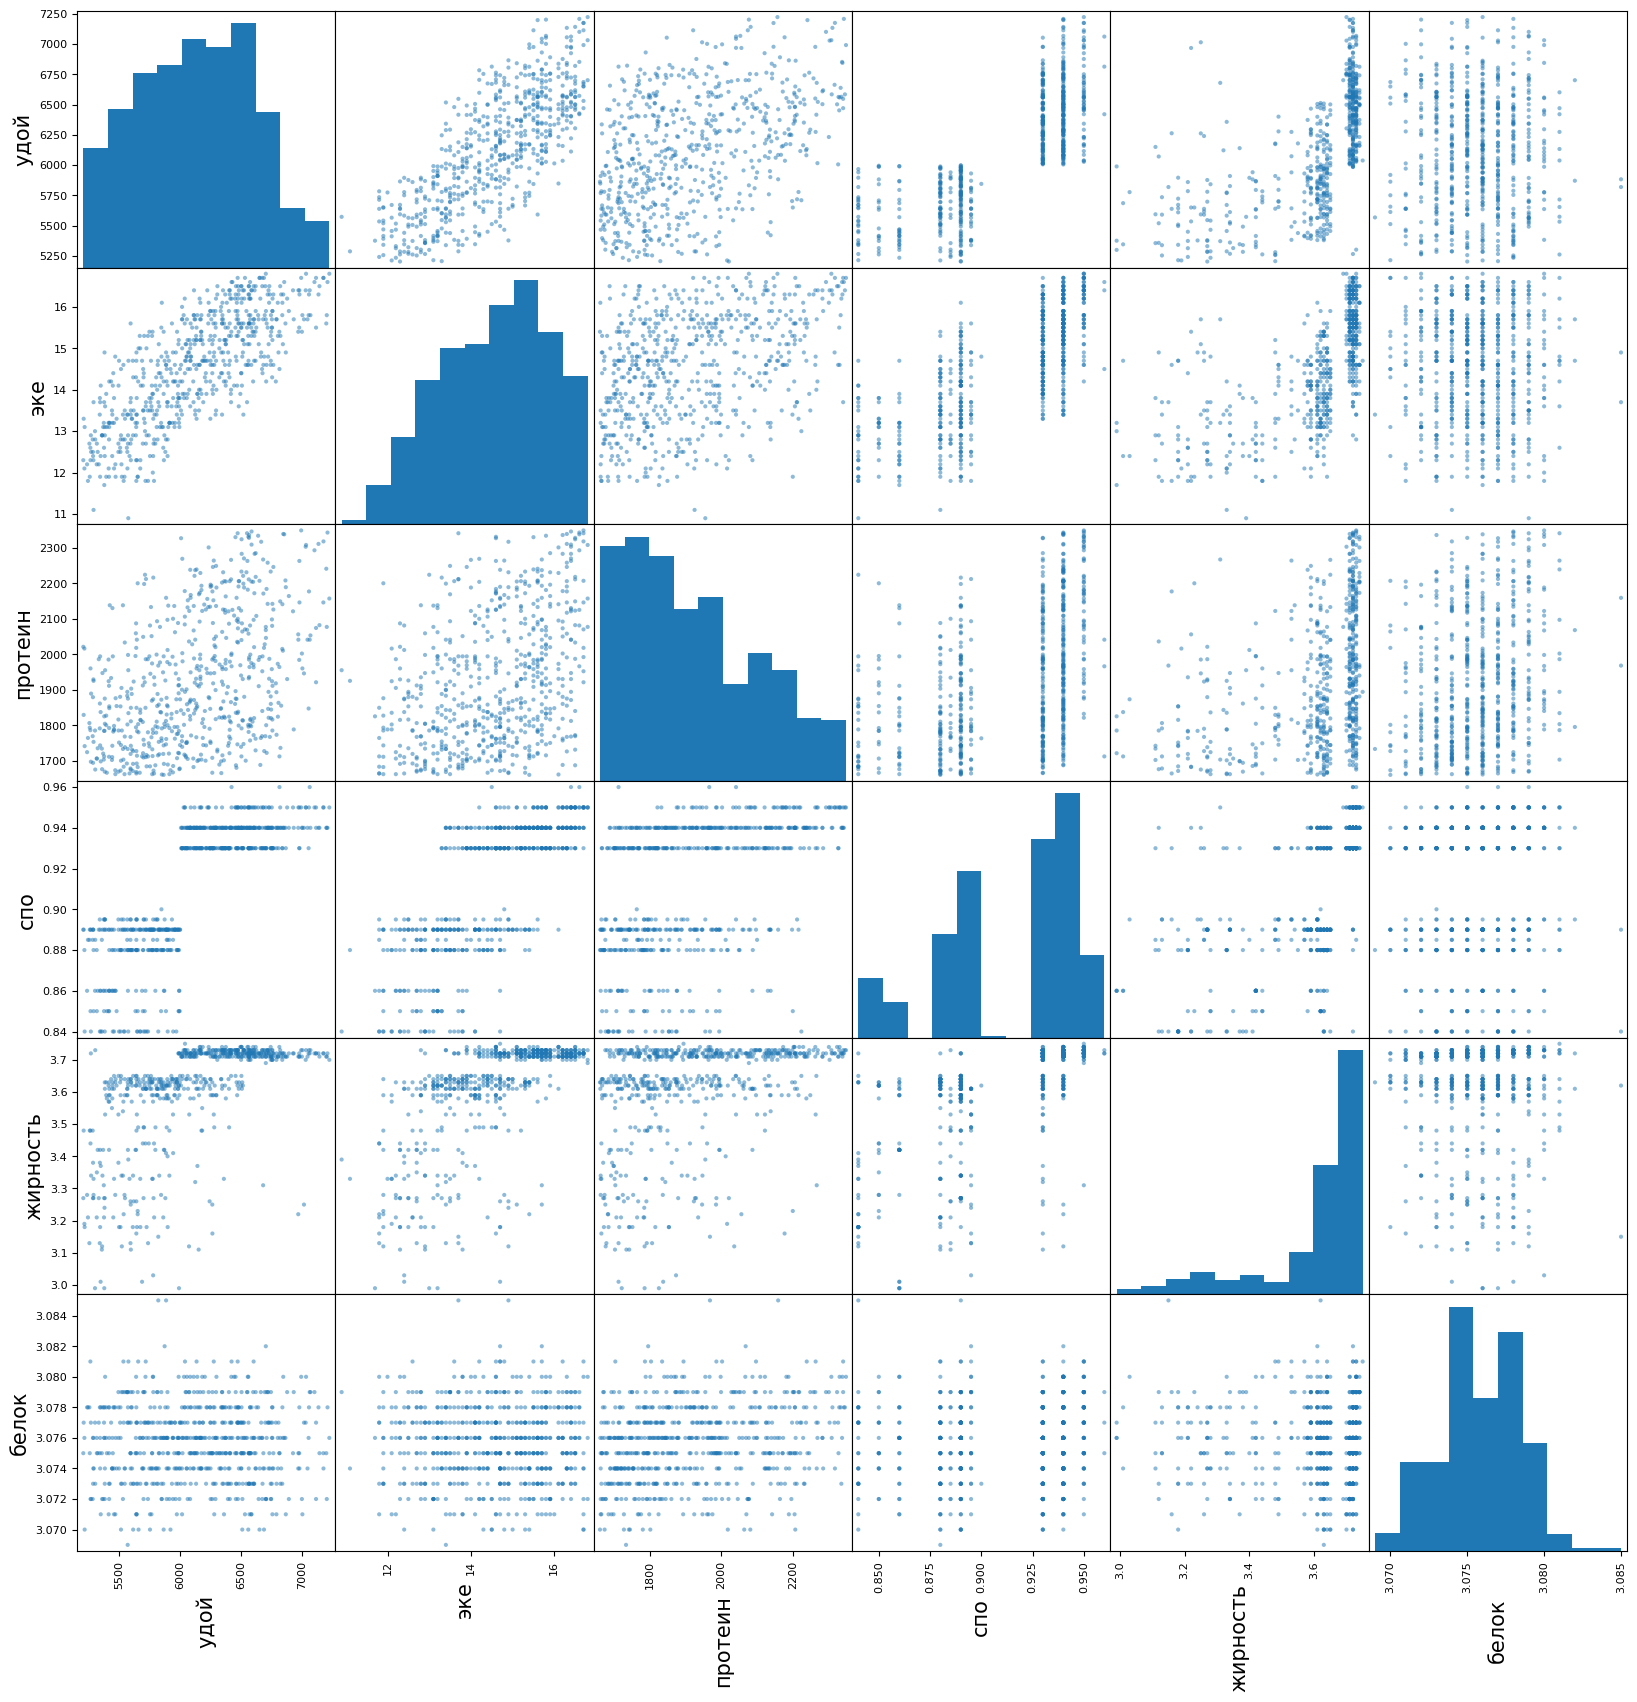

In [35]:
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(20,20));
for ax in scatter_matrix.ravel(): 
    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, rotation = 90) 
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, rotation = 90)

Если оценивать зависимости по матрице, можно заметить сильную линейную зависимость Удоя от ЭКЕ и более меньшую зависимость от содержания протеина, а Удой в зависимости от СПО распределен на кластеры начиная от точки в 6000 кг молока в год, и по числовым значениям хитмапа обладает высокой зависимостью(0.81).\

interval columns not set, guessing: ['удой', 'эке', 'протеин', 'спо', 'жирность', 'белок']


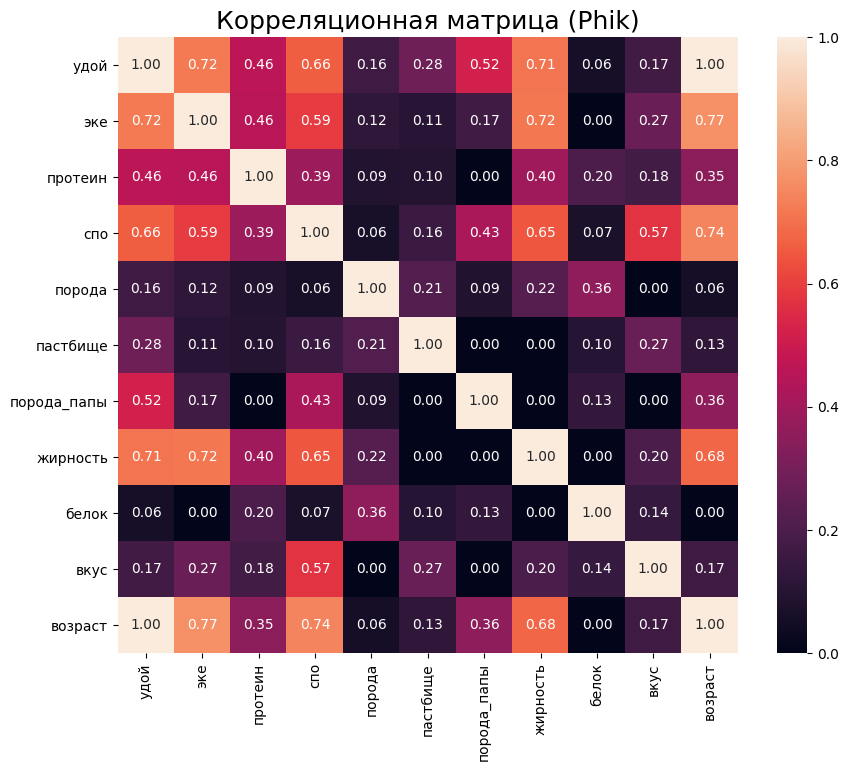

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.phik_matrix(), annot=True, fmt='.2f')
plt.title('Корреляционная матрица (Phik)', fontsize=18)
plt.show()

По корреляционной матрице Phik мы видим от каких категореальных переменных есть зависимость:
1. Удой имеет среднюю зависимость от породы папы.
2. Эке, не сильно влияет на вкус который оценивает фермер.
3. Спо влияет на вкус, судя по данным, а так же имеет среднюю зависимость от породы отца.
4. Порода самой коровы средне влияет на % белка в молоке.
5. Эке и Спо иммеют высокую корреляцию с возрастом скота, так же возраст скота сильно влияет на жирность молока.

## Вывод по разделу:
    1. Целевые признаки для фермера это Удой и Вкус молока.
    2. Как видно из исследования Удой сильно зависит от жирности молока, Эке и Спо.
    3. Вкус молока имеет среднеюю зависимость от Спо. 

## Обучение модели линейной регрессии

In [37]:
df_farm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           629 non-null    int64  
 1   удой         629 non-null    int64  
 2   эке          629 non-null    float64
 3   протеин      629 non-null    int64  
 4   спо          629 non-null    float64
 5   порода       629 non-null    object 
 6   пастбище     629 non-null    object 
 7   порода_папы  629 non-null    object 
 8   жирность     629 non-null    float64
 9   белок        629 non-null    float64
 10  вкус         629 non-null    object 
 11  возраст      629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


### Подготовим данные на основе прошлых выводов.
1. Уберем выбросы по удою, с числами более 10000
2. Превратим числовые данные спо, в категареальный признак на базе информации о границе в 0.900


In [38]:
df_farm = df_farm[df_farm['удой'] < 10000]

In [39]:
def model_lr(a, b, c, d):
    RANDOM_STATE = 42
    
    X = a.drop(b, axis=1)
    y = a[b]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE)
    
    cat_col_names = c
    num_col_names = d
    
    encoder = OneHotEncoder(drop='first', sparse=False) 
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    
    encoder_col_names = encoder.get_feature_names()
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
     
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    predictions = model_lr.predict(X_test)
    
    return [X_train, X_test, y_train, y_test, predictions, encoder, scaler, model_lr]

In [40]:
def r2(mod,a,b,c,d):
    
    r2_results=mod(a,b,c,d)       
    r2 = r2_score(r2_results[3], r2_results[4])
    print('Коэффициента детерминации R2=',r2)


In [41]:
def remain(mod,a,b,c,d):
    func = mod(a,b,c,d)
    remains = func[3] - func[4]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
    axes[0].hist(remains, bins=70)
    axes[0].set_title('Гистограмма распределения остатков', fontsize=14, fontweight="normal", color='black')
    axes[0].set_xlabel('Остатки', fontsize=14, fontweight="normal", color='black')
    
    axes[1].scatter(x=func[4],  y=remains, color = 'blue')
    axes[1].set_title('Дисперсия распределения остатков', fontsize=14, fontweight="normal", color='black')
    axes[1].set_xlabel('Предсказания модели', fontsize=14, fontweight="normal", color='black')
    axes[1].set_ylabel('Остатки', fontsize=14, fontweight="normal", color='black')

Сначала используем все данные с которыми есть зависимость у удоя.

In [42]:
a = df_farm
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода']
d = ['эке','спо','протеин']

In [43]:
model_lr(a,b,c,d)
r2(model_lr,a,b,c,d)

Коэффициента детерминации R2= 0.7844078173416967


None


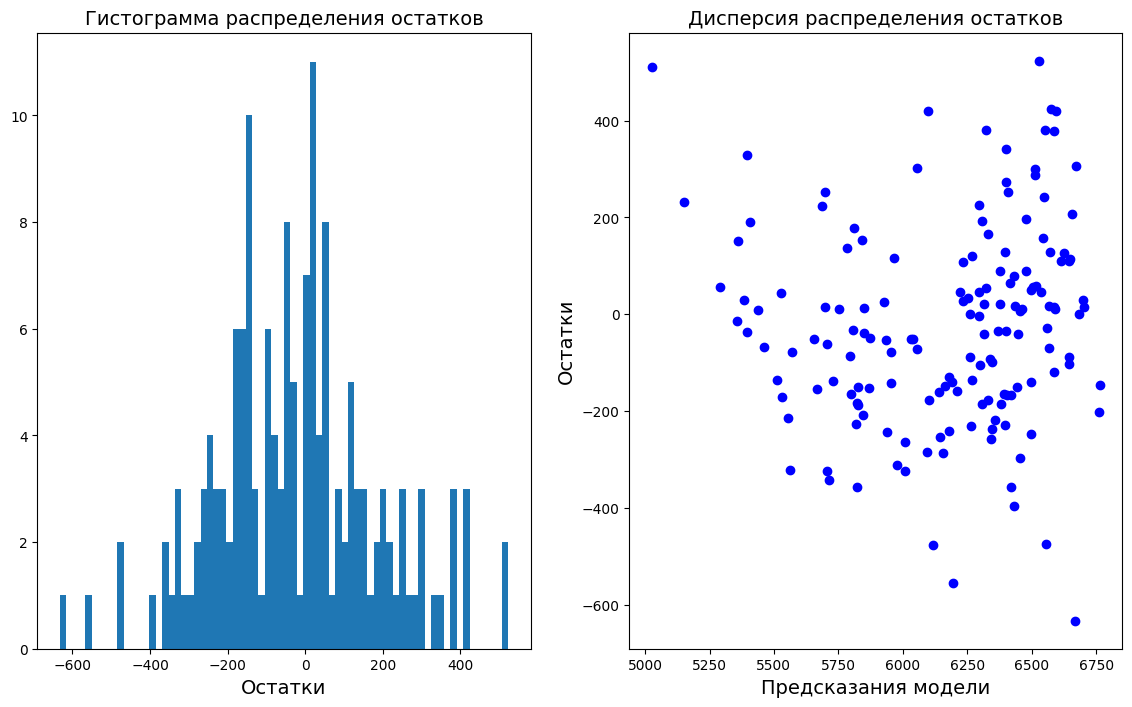

In [44]:
print(remain(model_lr,a,b,c,d))

#### Вывод:
1. Коэффициента детерминации R² первой модели равень 0.7844, что указывает на положительное качество модели.
2. При построении графика остатков можно заметить что они расположенны нормально относительно 0, пик на 0, но при этом есть значения рядом с -600 и 400+, что может указывать на аномалии.
3. По графику остатков и предсказаний, можно сделать вывод что разброс не имеет явных зависимостей. При  это есть выбросы на большие значения.

Проверим еще раз графики зависимостей Удоя от основных числовых характеристик

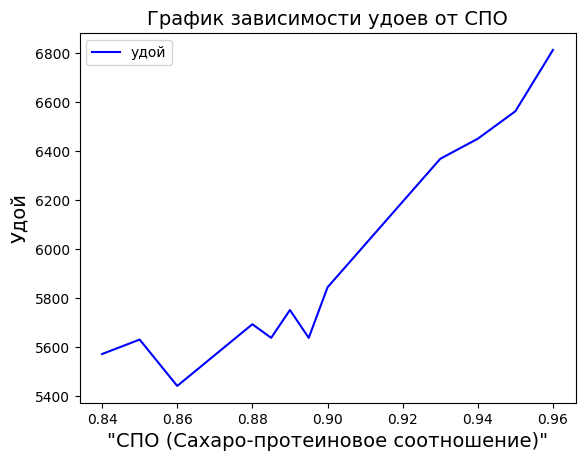

In [45]:
df_farm.pivot_table(index='спо', values='удой', aggfunc='median').plot(color = 'blue')
plt.xlabel('"СПО (Сахаро-протеиновое соотношение)"', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от СПО', fontsize=14, fontweight="normal", color='black')
plt.show()

Как мы видим по графику зависимости Удоя от СПО, линейная зависимость начинается от значения в 0.9. Выше в матрице зависимостей, мы наблюдали причину этого, до значения в 0.9 значения идут в одном кластере, после этого значения в другом, имеяя два кластера и линейную зависимость второго, мы можем превратить числовые данные в категореальные разбив их на две категории до значения в 0.9 и после.

In [46]:
df_farm['спо_кат'] = df_farm['спо'].apply(lambda x: 1 if x>=0.9 else 0 )

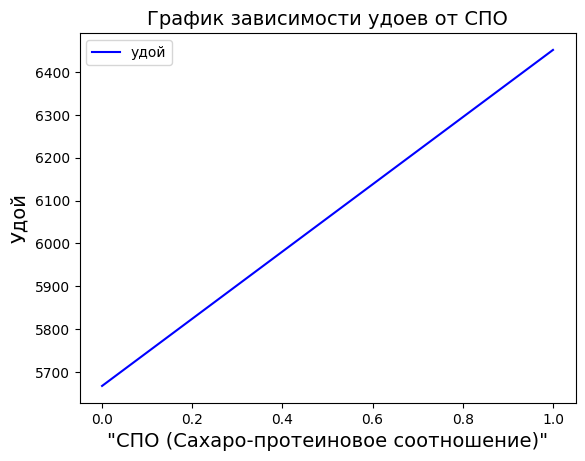

In [47]:
df_farm.pivot_table(index='спо_кат', values='удой', aggfunc='median').plot(color = 'blue')
plt.xlabel('"СПО (Сахаро-протеиновое соотношение)"', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от СПО', fontsize=14, fontweight="normal", color='black')
plt.show()

Как и ожидалось после этого мы видим идеальную линейную зависимость

<Figure size 1000x500 with 0 Axes>

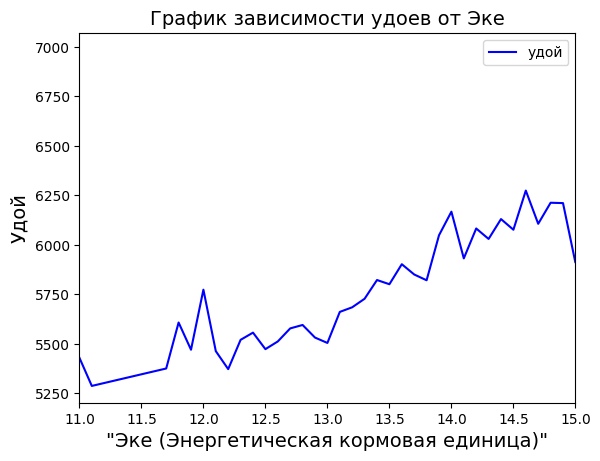

In [48]:
plt.figure(figsize=(10, 5))
df_farm.pivot_table(index='эке', values='удой').plot(color = 'blue')
plt.xlabel('"Эке (Энергетическая кормовая единица)"', fontsize=14)
plt.ylabel('Удой', fontsize=14, color='black')
plt.title('График зависимости удоев от Эке', fontsize=14)
plt.xlim(11,15)
plt.show()

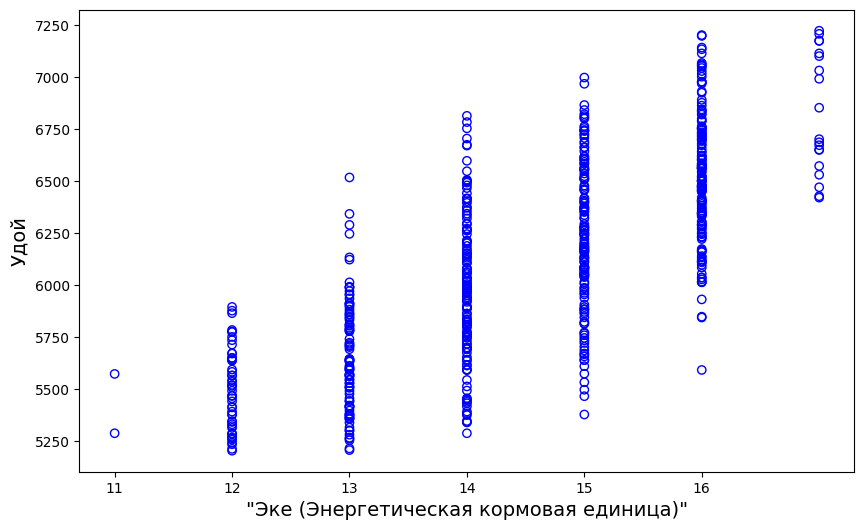

In [49]:
df_farm['эке_окр']= df_farm['эке'].round(0)
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('"Эке (Энергетическая кормовая единица)"', fontsize=14)
plt.ylabel('Удой', fontsize=14, fontweight="normal")
ax.scatter(df_farm['эке_окр'], df_farm['удой'], facecolors='none', edgecolors='blue')
plt.xticks([11,12,13,14,15,16])
plt.show()

По графику видим слабую линейную зависимость Удоя от Эке, возведем Эке в квадрат.

In [50]:
df_farm['эке_в_квадрате'] = df_farm['эке']**2

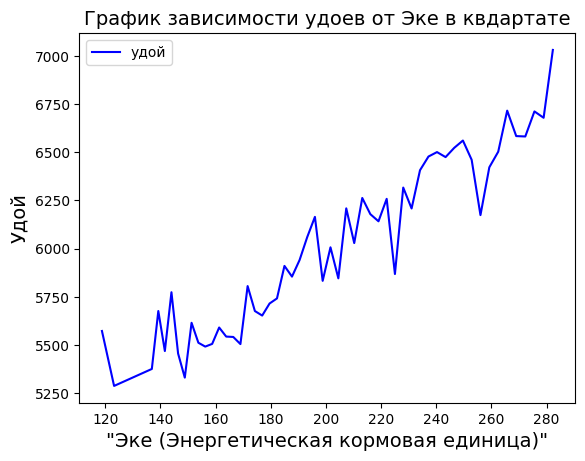

In [51]:
df_farm.pivot_table(index='эке_в_квадрате', values='удой', aggfunc='median').plot(color = 'blue')
plt.xlabel('"Эке (Энергетическая кормовая единица)"', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от Эке в квдартате', fontsize=14, fontweight="normal", color='black')
plt.show()

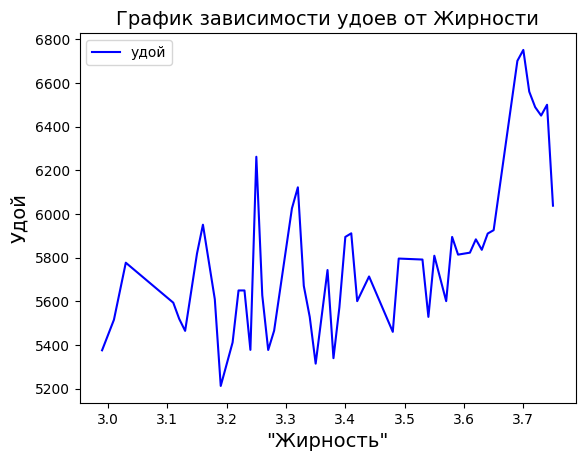

In [52]:
df_farm.pivot_table(index='жирность', values='удой', aggfunc='median').plot(color = 'blue')
plt.xlabel('"Жирность"', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от Жирности', fontsize=14, fontweight="normal", color='black')
plt.show()

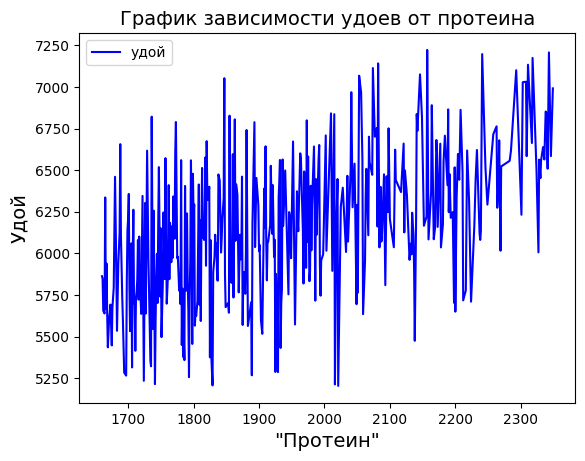

In [53]:
df_farm.pivot_table(index='протеин', values='удой', aggfunc='median').plot(color = 'blue')
plt.xlabel('"Протеин"', fontsize=14, fontweight="normal", color='black')
plt.ylabel('Удой', fontsize=14, fontweight="normal", color='black')
plt.title('График зависимости удоев от протеина', fontsize=14, fontweight="normal", color='black')
plt.show()

##### Вывод: По графикам зависимостей числовых харрактеристик, а именно Спо, Эке, и Жирности, мы привели СПО к категореальному признаку, Эке обладает линейной зависимостью, жирность же молока, не показывает линейную зависимость, а по диаграмме разброса выше вообще распределена на 3 кластера. Кол-во протеина же по диаграмме разброса показывает умеренную линейную зависимость, а график зависимости хоть и имеет скачки, показывает стабильный рост, обозначающий небольшую линейную зависимость, Уберем жирность из модели оставив только эке в квадрате и протеин.

In [54]:
a = df_farm
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода','спо_кат']
d = ['эке_в_квадрате','протеин']

Коэффициента детерминации R2= 0.817769634128236
None


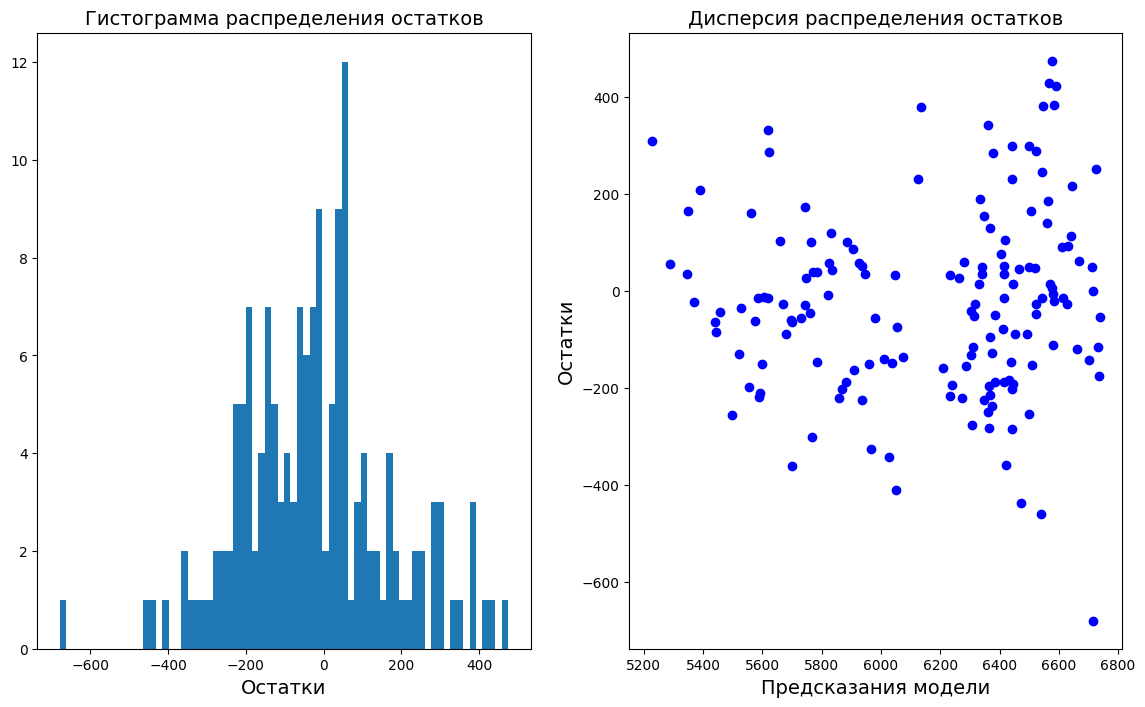

In [55]:
model_lr(a,b,c,d)
r2(model_lr,a,b,c,d)
print(remain(model_lr,a,b,c,d))

После изменения некоторых признаков видно, что коэффициент детерминации увеличился до 0.8177, что показывает улучшение качества модели, а дисперсия распределения остатков все так же показывает случаенность, и не имеет какой либо закономерности. На гистограмме так же видно, что пик остатков смещен в право, что указывает на недооценку некоторых значений.

#### Добавим имя папы в модель, и посмотрим результат.

In [56]:
df_ferm_dad = df_farm.merge(df_dad, on='id',how='left')

In [57]:
df_ferm_dad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              628 non-null    int64  
 1   удой            628 non-null    int64  
 2   эке             628 non-null    float64
 3   протеин         628 non-null    int64  
 4   спо             628 non-null    float64
 5   порода          628 non-null    object 
 6   пастбище        628 non-null    object 
 7   порода_папы     628 non-null    object 
 8   жирность        628 non-null    float64
 9   белок           628 non-null    float64
 10  вкус            628 non-null    object 
 11  возраст         628 non-null    object 
 12  спо_кат         628 non-null    int64  
 13  эке_окр         628 non-null    float64
 14  эке_в_квадрате  628 non-null    float64
 15  имя_папы        628 non-null    object 
dtypes: float64(6), int64(4), object(6)
memory usage: 83.4+ KB


In [58]:
a = df_ferm_dad
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода','спо_кат','имя_папы']
d = ['эке_в_квадрате','протеин']

Коэффициента детерминации R2= 0.8245196485602116
None


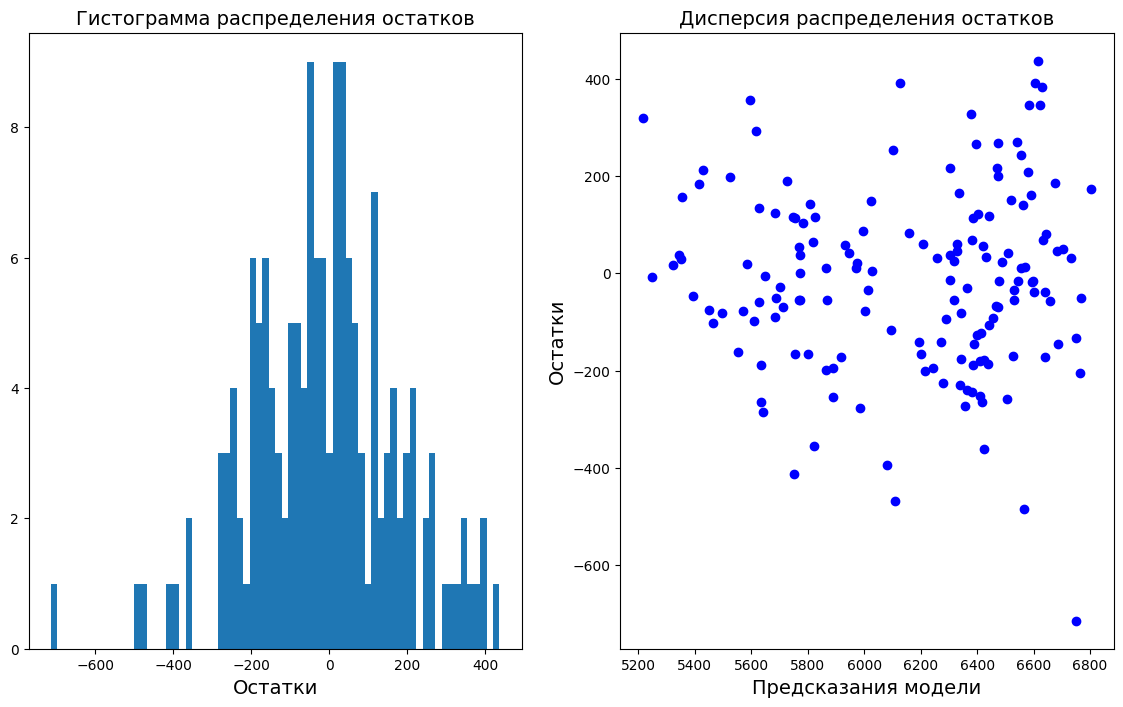

In [59]:
model_lr(a,b,c,d)
r2(model_lr,a,b,c,d)
print(remain(model_lr,a,b,c,d))

##### Вывод: После добавления имя папы в модель, коэффициент дитерминации увеличился до 0.0.8245, по гистограмме распределения остатотков, видно что остатки размещенны нормально, с двумя пиками близ 0. 

### Оценим качество трех моделей.

##### Создадим функции для подсчета MSE, MAE, RMSE

In [60]:
def mse(mod,a,b,c,d):    
    mse_results=mod(a,b,c,d)       
    mse = mean_squared_error(mse_results[3], mse_results[4])
    print('Средне квадратичная ошибка mse =',mse)

    
def mae(mod,a,b,c,d):
    mae_results=mod(a,b,c,d)
    mae = mean_absolute_error(mae_results[3], mae_results[4])
    print('Средння абсолютная ошибка mae =',mae)

    
def rmse(mod,a,b,c,d):
    rmse_results=mod(a,b,c,d)
    rmse = mean_squared_error(rmse_results[3], rmse_results[4], squared=False)
    print('Средння ошибка rmse =',rmse)
    

Выведем все метрики для 1 модели:

In [61]:
a = df_farm
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода']
d = ['эке','жирность','спо','протеин']

In [62]:
model_lr(a,b,c,d)
r2(model_lr,a,b,c,d)
mse(model_lr,a,b,c,d)
mae(model_lr,a,b,c,d)
rmse(model_lr,a,b,c,d)

Коэффициента детерминации R2= 0.7840491770333317
Средне квадратичная ошибка mse = 43960.021611301694
Средння абсолютная ошибка mae = 163.6199879790965
Средння ошибка rmse = 209.66645323299028


Выведем все метрики для 2 модели:

In [63]:
a = df_farm
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода','спо_кат']
d = ['эке_в_квадрате','протеин']

In [64]:
model_lr(a,b,c,d)
r2(model_lr,a,b,c,d)
mse(model_lr,a,b,c,d)
mae(model_lr,a,b,c,d)
rmse(model_lr,a,b,c,d)

Коэффициента детерминации R2= 0.817769634128236
Средне квадратичная ошибка mse = 37095.717959799666
Средння абсолютная ошибка mae = 149.15000962733424
Средння ошибка rmse = 192.60248689931203


Выведем все метрики для 3 модели:

In [65]:
a = df_ferm_dad
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода','спо_кат','имя_папы']
d = ['эке_в_квадрате','протеин']

In [66]:
model_lr(a,b,c,d)
r2(model_lr,a,b,c,d)
mse(model_lr,a,b,c,d)
mae(model_lr,a,b,c,d)
rmse(model_lr,a,b,c,d)

Коэффициента детерминации R2= 0.8245196485602116
Средне квадратичная ошибка mse = 35721.65151156925
Средння абсолютная ошибка mae = 146.27150820234186
Средння ошибка rmse = 189.0017235677211


### Вывод по трем моделям:
    Лучше всего себя показывает 3 модель, значение R2 ближе всего к 1. 
    По mse ошибается меньше на 2 тысячи чем вторая модель, и на 8 тысяч чем первая модель.
    По mae так же видно что ошибка самая минимальная среди трех моделей.
    По rmse так же самое низкое среди 3 моделей. Для дальнейшей работы выбираем 3 модель.

Найдем квартили ошибки для последней модели.

In [67]:
def quantiles(mod,a,b,c,d):
    func = mod(a,b,c,d)
    remains = func[3] - func[4]
    quantiles = remains.quantile([0.025, 0.975])
    return quantiles

In [68]:
quantiles(model_lr,a,b,c,d).round(2)

,удой
0.025,-395.51
0.975,358.36


Доверительный интервал составляет от -420.14 до 422.47

Сделаем прогноз по удою, для коров с эко фермы. Для этого добавим данные в датафрейм с информацией о коровах с фермы и используем 3 модель.

In [69]:
df_buy['спо'] = df_ferm_dad['спо'].mean()*1.05
df_buy['эке'] = df_ferm_dad['эке'].mean()*1.05
df_buy['эке_в_квадрате'] = df_buy['эке']**2
df_buy['протеин'] = df_ferm_dad['протеин'].mean()*1.05
df_buy['удой'] = 0
df_ferm_dad['спо']

0      0.890
1      0.890
2      0.885
3      0.885
4      0.885
       ...  
623    0.940
624    0.880
625    0.880
626    0.890
627    0.940
Name: спо, Length: 628, dtype: float64

In [70]:
a = df_buy
b = ['удой']
c = ['пастбище','порода_папы','возраст','порода','спо_кат','имя_папы']
d = ['эке_в_квадрате','протеин']

In [71]:
df_buy['спо_кат'] = df_buy['спо'].apply(lambda x: 1 if x>=0.9 else 0 )

In [72]:
X_train = df_ferm_dad
X_test = df_buy

target = 'удой'
cat_col_names = ['пастбище','порода_папы','возраст','порода','спо_кат','имя_папы']
num_col_names = ['эке_в_квадрате','протеин']

X = X_train.drop(target, axis=1)
y = X_train[target]


encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
X_ohe = encoder.fit_transform(X[cat_col_names])
encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)

model_lr  = LinearRegression()
model_lr.fit(X, y)


X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)

predictions = model_lr.predict(X_cow)

print(predictions)



[6574. 6310. 6312. 6604. 6558. 6390. 6526. 6388. 6338. 6606. 6574. 6086.
 6604. 6338. 6390. 6526.]


In [73]:
for i in range(len(df_buy['удой'])):
    df_buy.loc[i,'удой'] = predictions[i]

In [74]:
df_buy.sort_values(by = 'удой', ascending = False)


,порода,пастбище,порода_папы,имя_папы,жирность,белок,возраст,спо,эке,эке_в_квадрате,протеин,удой,спо_кат
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.13,3.073,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6606.0,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6604.0,1
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.72,3.065,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6604.0,1
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6574.0,1
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.13,3.046,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6574.0,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.73,3.074,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6558.0,1
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.48,3.079,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6526.0,1
15,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.73,3.069,более_2_лет,0.958744,15.276162,233.361138,2019.947532,6526.0,1
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.13,3.053,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6390.0,1
14,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.71,3.053,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6390.0,1


### Вывод:
    1. По предсказанным значениям подходят 16 коров, так как дают более 6000 кг молока в год.
    2. Лучшей моделью признана 3 модель.

## Обучение модели логистической регрессии

In [75]:
df_farm

,id,удой,эке,протеин,спо,порода,пастбище,порода_папы,жирность,белок,вкус,возраст,спо_кат,эке_окр,эке_в_квадрате
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,14.0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,13.0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,14.0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,12.0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,13.0,163.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,1,15.0,237.16
625,626,5513,12.9,1700,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,0,13.0,166.41
626,627,5970,14.4,1837,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,0,14.0,207.36
627,628,5746,13.8,1994,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,0,14.0,190.44


In [76]:
df_farm['возраст'] = df_farm['возраст'].apply(lambda x: 1 if x == 'более_2_лет' else 0)
df_farm['вкус'] = df_farm['вкус'].apply(lambda x: 1 if x == 'вкусно' else 0)
df_buy['вкус'] = 0

 Accuracy =  0.6050955414012739 
 Precision =  0.6065573770491803 
 Recall =  0.8409090909090909 


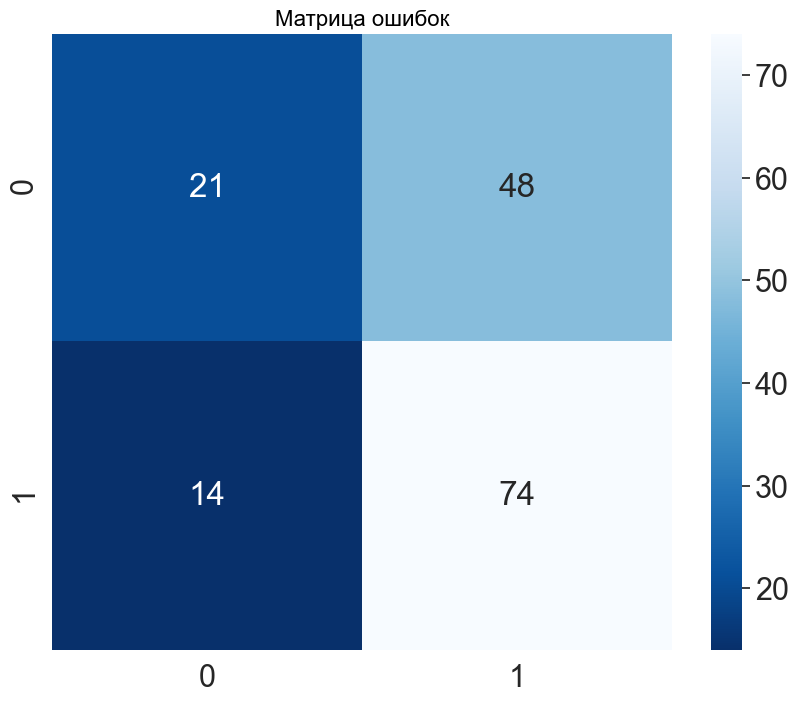

In [77]:
a = df_farm
b = 'вкус'
c = ['порода','пастбище','порода_папы','возраст']
d = ['эке','спо','протеин','жирность','белок']

RANDOM_STATE = 42

X = a.drop(b, axis=1)
y = a[b]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = c
num_col_names = d

encoder = OneHotEncoder(drop='first', sparse=False) 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)  
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)       

plt.figure(figsize = (10,8))
cm = confusion_matrix(y_test, y_pred)

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок', fontsize=16, fontweight="normal", color='black')
print('\u001b[38;5;19m', 'Accuracy = ',acc,'\u001b[0m')
print('\u001b[38;5;19m', 'Precision = ',precision,'\u001b[0m')
print('\u001b[38;5;19m', 'Recall = ',recall,'\u001b[0m')

1. По результатам видно что Recall больше Precision. 
2.Модель предсказывает, что 14 коров дают не вкусное молоко, при этом оно вкусное, и 48 раз предсказывает, что корова дает вкусное молоко, при этом оно не вкусное. Так как нам требуется, минимизировать возможность покупка коров с невкусным молоком, надо минимизировать данное значение.

In [78]:
a = df_farm
b = 'вкус'
c = ['порода','пастбище','порода_папы','возраст']
d = ['эке','спо','протеин','жирность','белок']

RANDOM_STATE = 42

X = a.drop(b, axis=1)
y = a[b]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = c
num_col_names = d

encoder = OneHotEncoder(drop='first', sparse=False) 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

y_proba = clf.predict_proba(X_test)[:,1]  #[:,1] > porog     #cow_buy['pred_proba'] = clf.predict_proba(X_cow)[:,1] > 0.66

data = pd.DataFrame(zip(y_test, y_proba, y_pred), columns = ['y_valid', 'y_proba', 'y_pred']).sort_values(by='y_proba',ascending=False)

data

,y_valid,y_proba,y_pred
33,0,0.848273,1
17,1,0.827808,1
85,1,0.819860,1
66,1,0.810052,1
95,1,0.790444,1
...,...,...,...
23,1,0.308969,0
46,0,0.297931,0
102,1,0.290560,0
144,0,0.247258,0


In [79]:
y_pred = clf.predict(X_test)  
y_proba = clf.predict_proba(X_test)[:, 1]

data = pd.DataFrame(zip(y_test, y_proba, y_pred), columns=['y_valid', 'y_proba', 'y_pred']).sort_values(by='y_proba', ascending=False)

display(data)

,y_valid,y_proba,y_pred
33,0,0.848273,1
17,1,0.827808,1
85,1,0.819860,1
66,1,0.810052,1
95,1,0.790444,1
...,...,...,...
23,1,0.308969,0
46,0,0.297931,0
102,1,0.290560,0
144,0,0.247258,0


In [80]:
thresholds = np.linspace(0.1, 1, num=2000, endpoint=False)
thresholds = [round(i, 2) for i in thresholds]

In [81]:
columns = []

for i in thresholds:
    column_name = 'y_pred_{}'.format(i)
    columns.append(column_name)
    data[column_name] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

display(data.head())

,y_valid,y_proba,y_pred,y_pred_0.1,y_pred_0.11,y_pred_0.12,y_pred_0.13,y_pred_0.14,y_pred_0.15,y_pred_0.16,...,y_pred_0.91,y_pred_0.92,y_pred_0.93,y_pred_0.94,y_pred_0.95,y_pred_0.96,y_pred_0.97,y_pred_0.98,y_pred_0.99,y_pred_1.0
33,0,0.848273,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
17,1,0.827808,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
85,1,0.819860,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66,1,0.810052,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
95,1,0.790444,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [82]:
for i in thresholds:
    cm = confusion_matrix(y_test, data['y_pred_'+str(i)])
    if cm[0][1] == 0:
        print('Порог = ',i ,'Precision = ', round(precision_score(y_test, data['y_pred_'+str(i)]), 2), 'TP =', cm[1][1])
        porog = i
        break

Порог =  0.82 Precision =  1.0 TP = 2


Accuracy =  0.45 
Precision =  1.0 
Recall =  0.02 


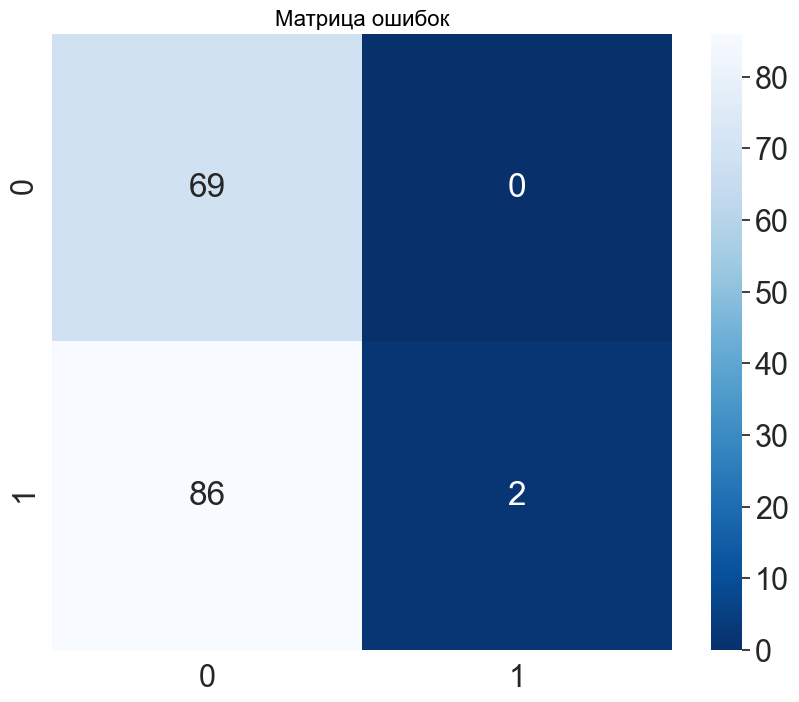

In [83]:
acc = round(accuracy_score(y_test, data['y_pred_'+str(porog)]), 2)
precision = round(precision_score(y_test, data['y_pred_'+str(porog)]), 2)
recall = round(recall_score(y_test, data['y_pred_'+str(porog)]), 2)

plt.figure(figsize = (10,8))
cm = confusion_matrix(y_test, data['y_pred_'+str(porog)])

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок', fontsize=16, fontweight="normal", color='black')
print("Accuracy = ", acc, "\x1b[0m")
print("Precision = ", precision, "\x1b[0m")
print("Recall = ", recall, "\x1b[0m") 

При значении порога в 0.82 мы получим полноценный результат с поиском коров, и не будет ошибок при которых вкусное молоко,классифицируется как не вкусное.

In [84]:
X_train = df_ferm_dad
X_test = df_buy

target = 'вкус'
cat_col_names = ['порода', 'пастбище', 'порода_папы', 'возраст']
num_col_names = ['эке', 'протеин','спо', 'жирность' , 'белок']

X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_ohe = encoder.fit_transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)
                  
clf = LogisticRegression()
clf = clf.fit(X, y)

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)   

y_pred = clf.predict_proba(X_cow)[:,1] 

df_buy['y_pred'] = y_pred

df_buy['вкус'] = df_buy['y_pred'].apply(lambda x: 'вкусно' if x > 0.70 else 'не вкусно')      
df_buy['возраст'] = df_buy['возраст'].apply(lambda x: 'более_2_лет' if x == 1 else 'менее_2_лет')

df_buy = df_buy.sort_values(by = ['y_pred'], ascending = False)
df_buy = df_buy.drop(columns='y_pred') 

df_buy

,порода,пастбище,порода_папы,имя_папы,жирность,белок,возраст,спо,эке,эке_в_квадрате,протеин,удой,спо_кат,вкус
14,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.71,3.053,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6390.0,1,вкусно
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.13,3.046,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6574.0,1,вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.13,3.053,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6390.0,1,не вкусно
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.71,3.055,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6338.0,1,не вкусно
15,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.73,3.069,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6526.0,1,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6604.0,1,не вкусно
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.72,3.065,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6604.0,1,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.73,3.074,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6558.0,1,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6312.0,1,не вкусно
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.13,3.073,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6606.0,1,не вкусно


In [85]:
df_buy.query('вкус == "вкусно" & удой >= 6000')

,порода,пастбище,порода_папы,имя_папы,жирность,белок,возраст,спо,эке,эке_в_квадрате,протеин,удой,спо_кат,вкус
14,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.71,3.053,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6390.0,1,вкусно
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.13,3.046,менее_2_лет,0.958744,15.276162,233.361138,2019.947532,6574.0,1,вкусно


## Итоговые выводы
### Обработка данных: 
    1.Были выявленны и удалены дупликаты из баз.
    2.Приведен текст к нижнему регистру.
    3.Переименнованны некоторые данные для лучшего восприятия.
### Исследовательский анализ данных.
    1.Проведена оценка зависимостей между признакими в данных от фермера.
    2. Скоректированны некоторые данные. 
    3. Построенны 3 хитмапа для оценки этих зависимостей. А так же большая матрица.
### Прогнозирование удоя. 
    1. Построенно 3 модели линейной регрессии:
        1. В первой модели все данные были изначальные и не изменненные, путем анализа выяснилось, что некоторые чилсовые данные можно представить в виде категореальнныйх из за кластерной зависимости.(Спо(Сахаро-протеиновое соотношение))
        2. Во второй модели внесли уже измененнные данные, отнесли СПО к категориальным признакам. Эке(Энергетическая кормовая единица) имела слабую линейную зависимость с удоем, возвели данные в квадрат, для улучшения данных.
        3. В 3 модели добавили данные об отцах коров, что позволило увеличить точность модели. При таком наборе данных: 
            Коэффициента детерминации R2= 0.8245196485602116
            Средне квадратичная ошибка mse = 35721.65151156924
            Средння абсолютная ошибка mae = 146.2715082023418
            Средння ошибка rmse = 189.00172356772103
            Это указывает на достаточно высокие шансы определить удой у предлагаемых фермой коров, при этом доверительный интервал составил от -420.14 до 422.47, что указывает на достаточно низкую погрешность, при определении предсказний. 
            Третья модель была выбрана как самая оптимальная, и точная в предсказаниях по удою коров. И после работы модели, оказалось что почти все коровы соотвествуют требованию фермера, по удою более 6000 кг молока в год.
### Предсказание вкуса молока, у коров с эко фермы.
    1. Создав модель линейной классификации, и построив матрицу ошибок, было выявлено 48 ложно-положительный предсказаний, который могли повлиять на результат работы модели. Так как фермеру требуется минимизировать такой исход, и что что бы в список корово которые ему рекомендованны к покупке, не попапали коровы которые дают не вкусное молоко, был изменен порог оценки классификации, при котором, риск купить корову с плохим молоком был самым низким. Порог при этом составил 0.70.
    2. По итогам работы модели, можно рекомендовать 2 коровы, которые дают более 6000 кг молока в год, и при этом по субъективным оценкам фермера дают вкусное молоко.
    3. Id этих коров 10 и 14 соотвественно. При покупке данных коров, риск разочарования для фермера минимален.